## Yahoo Finance Dataset Download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# module to download dataset

!pip install yahoo_fin
!pip install requests_html

## Mount Google Drive

In [ ]:
# Google Drive mount

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Models Building Begins

In [29]:
# import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from yahoo_fin.stock_info import get_data
from yahoo_fin import stock_info as si
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


## Dataset Display

In [30]:
# date range of last one year

stock_start_date = '06/01/2023'
stock_end_date = '06/30/2024'


# list of NIFTY 50 Stocks that are ethically approved

approved_stocks = [
    'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'HINDUNILVR.NS',
    'HCLTECH.NS', 'WIPRO.NS', 'TECHM.NS', 'NESTLEIND.NS', 'BAJFINANCE.NS',
    'ICICIBANK.NS', 'LT.NS', 'ASIANPAINT.NS', 'KOTAKBANK.NS', 'TITAN.NS',
    'M&M.NS', 'MARUTI.NS', 'ULTRACEMCO.NS', 'SBILIFE.NS', 'DIVISLAB.NS'
]


# Fetch stock data for each company
nifty_stock_historical = {}
for ticker in approved_stocks:
    nifty_stock_historical[ticker] = si.get_data(ticker,
                                                 start_date=stock_start_date,
                                                 end_date=stock_end_date,
                                                 interval="1d")


# converting dictionary into multi-index dataframe

stock_df = pd.concat(nifty_stock_historical, axis=0)
stock_df.index.names = ['Ticker', 'Date']


# converting index level into DateTime format

stock_df.reset_index(level='Date', inplace=True)
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df.set_index('Date', append=True, inplace=True)
stock_df.to_csv('nifty_50.csv') # converting dataframe to csv format


# display output format
print(stock_df.head()  )

                               open         high          low        close  \
Ticker      Date                                                             
RELIANCE.NS 2023-06-01  2289.177734  2293.562012  2268.733154  2273.578857   
            2023-06-02  2280.732178  2291.669678  2262.272217  2266.148682   
            2023-06-05  2277.224854  2292.500488  2269.148438  2286.500977   
            2023-06-06  2292.223633  2296.146240  2272.425293  2288.439209   
            2023-06-07  2295.500244  2307.499268  2282.208984  2305.791748   

                           adjclose   volume       ticker  
Ticker      Date                                           
RELIANCE.NS 2023-06-01  2257.912354  7296346  RELIANCE.NS  
            2023-06-02  2250.533447  7900322  RELIANCE.NS  
            2023-06-05  2270.745605  5454341  RELIANCE.NS  
            2023-06-06  2272.670410  3746654  RELIANCE.NS  
            2023-06-07  2289.903564  5156272  RELIANCE.NS  


## Dataset Statistics

In [31]:
# load dataset

stock_data = pd.read_csv('/content/drive/MyDrive/Project/Nifty Stocks.csv')


# print shape of dataset

print(f"Number of Rows: {stock_data.shape[0]}")
print(f"Number of Columns: {stock_data.shape[1]}")


# print first few rows of dataset

print("\nTop Rows of The Dataset: ")
print(stock_data.head())


# print summary statistics of dataset

print("\nSummary Statistics of NIFTY50 Dataset: ")
print(stock_data.describe())


Number of Rows: 5280
Number of Columns: 9

Top Rows of The Dataset: 
        Ticker        Date         open         high          low  \
0  RELIANCE.NS  2023-06-01  2289.177734  2293.562012  2268.733154   
1  RELIANCE.NS  2023-06-02  2280.732178  2291.669678  2262.272217   
2  RELIANCE.NS  2023-06-05  2277.224854  2292.500488  2269.148438   
3  RELIANCE.NS  2023-06-06  2292.223633  2296.146240  2272.425293   
4  RELIANCE.NS  2023-06-07  2295.500244  2307.499268  2282.208984   

         close     adjclose   volume       ticker  
0  2273.578857  2265.575928  7296346  RELIANCE.NS  
1  2266.148682  2258.171875  7900322  RELIANCE.NS  
2  2286.500977  2278.452393  5454341  RELIANCE.NS  
3  2288.439209  2280.383789  3746654  RELIANCE.NS  
4  2305.791748  2297.675293  5156272  RELIANCE.NS  

Summary Statistics of NIFTY50 Dataset: 
               open          high           low         close      adjclose  \
count   5280.000000   5280.000000   5280.000000   5280.000000   5280.000000   
mean 

## Adjusted Close Price EDA (Exploratory Data Analysis) on Dataset

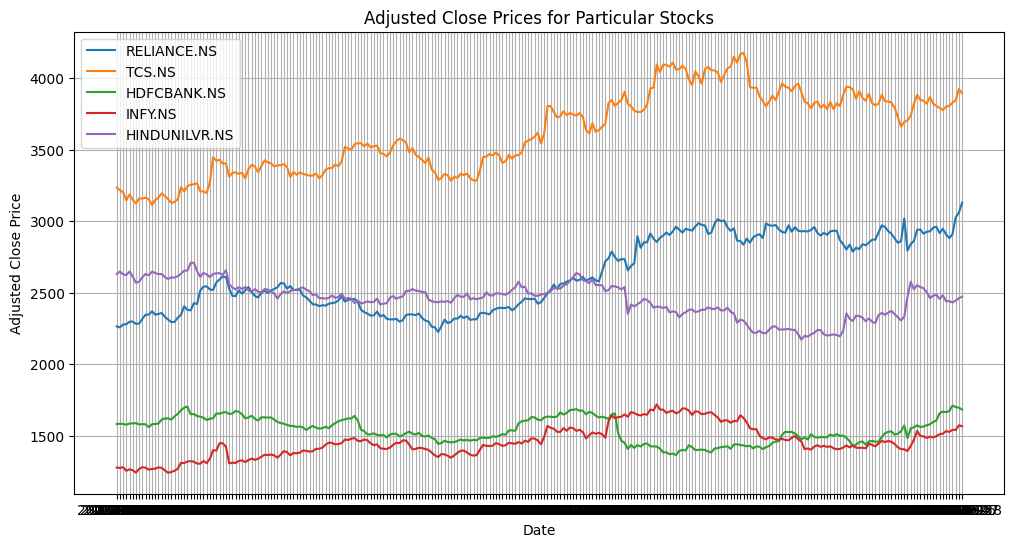

In [32]:
# evaluate daily returns for each company

stock_data['daily_return'] = stock_data.groupby('Ticker')['adjclose'].pct_change()


# plot adjusted close price for 5 stocks

plt.figure(figsize=(12, 6))
selected_stocks = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'HINDUNILVR.NS']

for ticker in selected_stocks:
  selected_stock_data = stock_data[stock_data['Ticker'] == ticker]
  plt.plot(selected_stock_data['Date'], selected_stock_data['adjclose'],
           label=ticker)

plt.title('Adjusted Close Prices for Particular Stocks')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()


## Volume EDA on Dataset

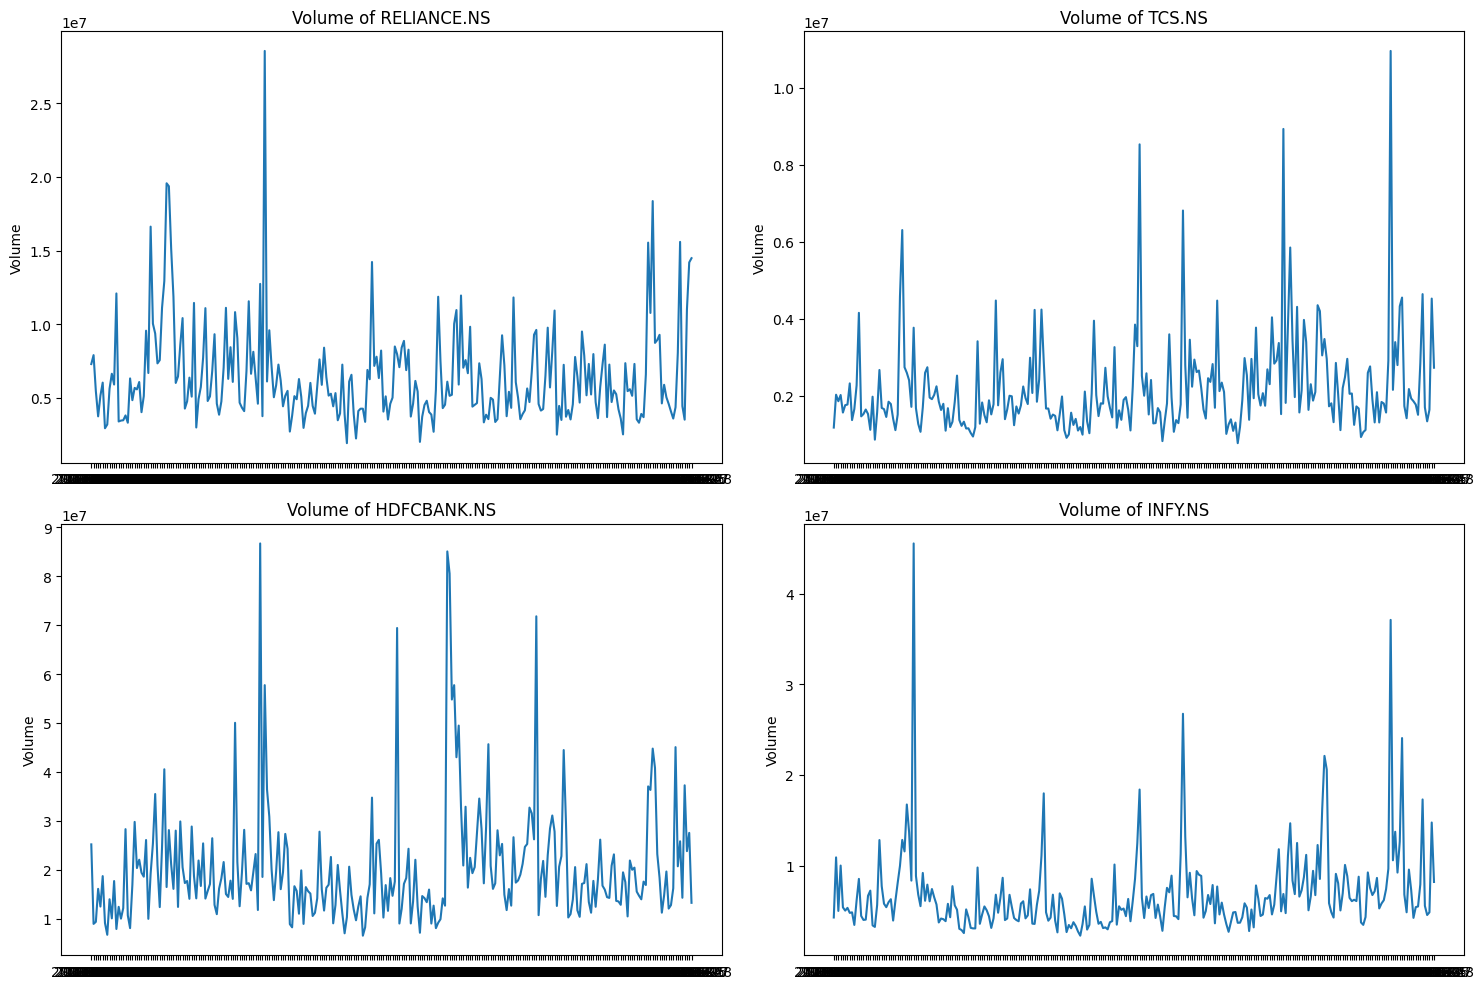

In [33]:
# list of selected companies

tickers = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS']

# plot subplots for Volume of different companies

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.3, wspace=0.2)

for i, ticker in enumerate(tickers, 1):
  plt.subplot(2, 2, i) # create a 2x2 grid of subplots
  ticker_data = stock_data[stock_data['Ticker'] == ticker] # filtering data for present company
  plt.plot(ticker_data['Date'], ticker_data['volume']) # plot the volume
  plt.ylabel('Volume') # label for y-axis
  plt.xlabel(None)
  plt.title(f"Volume of {ticker}") #title for each subplot


# layout adjustments of Volume

plt.tight_layout()
plt.show()

## Calculate RSI and Technical Indicators

In [34]:
# calculate RSI using function

def compute_rsi(series, period=14):
  delta = series.diff(1)
  gain = (delta.where(delta > 0, 0)).rolling(window=period).mean() # calculate the average gain of period
  loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean() # calculate the average loss of period
  rs = gain / loss
  return 100 - (100 / (1 + rs))


# calculate Technical Indicators using function

def calculate_technical_indicators(df_stock_data):
  df_stock_data['7-day SMA'] = df_stock_data['close'].rolling(window=7).mean() # for the short term analysis using 7 window size
  df_stock_data['30-day SMA'] = df_stock_data['close'].rolling(window=30).mean() # for the short term analysis using 30 window size
  df_stock_data['12-day EMA'] = df_stock_data['close'].ewm(span=12, adjust=False).mean()
  df_stock_data['26-day EMA'] = df_stock_data['close'].ewm(span=26, adjust=False).mean()
  df_stock_data['RSI'] = compute_rsi(df_stock_data['close'])
  df_stock_data['lag_1'] = df_stock_data['close'].shift(1) # create a lag feature to capture short term movements
  df_stock_data['lag_2'] = df_stock_data['close'].shift(2)
  df_stock_data['lag_5'] = df_stock_data['close'].shift(5)
  df_stock_data['lag_10'] = df_stock_data['close'].shift(10)
  return df_stock_data.dropna()


# add technical features to whole dataset

stock_data = stock_data.groupby('ticker').apply(calculate_technical_indicators).reset_index(drop=True)
print(stock_data.head())

def plot_technical_indicators(df, ticker):
  plt.figure(figsize=(14, 7))

  # plot adjusted close price and SMAs

  plt.subplot(2, 1, 1)
  plt.plot(df['Date'], df['adjclose'], label='Close Price', color='blue')
  plt.plot(df['Date'], df['7-day SMA'], label='7-day SMA', color='red', linestyle='--')
  plt.plot(df['Date'], df['30-day SMA'], label='30-day SMA', color='green', linestyle='--')
  plt.title(f'{ticker} Price and Moving Averages')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.grid(True)


  # plot EMAs

  plt.subplot(2, 1, 2)
  plt.plot(df['Date'], df['adjclose'], label='Close Price', color='blue')
  plt.plot(df['Date'], df['12-day EMA'], label='12-day EMA', color='orange', linestyle='--')
  plt.plot(df['Date'], df['26-day EMA'], label='26-day EMA', color='purple', linestyle='--')
  plt.title(f'{ticker} Price and EMAs')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()

          Ticker        Date         open    high          low        close  \
0  ASIANPAINT.NS  2023-07-13  3425.000000  3425.0  3384.350098  3398.550049   
1  ASIANPAINT.NS  2023-07-14  3398.550049  3439.0  3387.000000  3429.750000   
2  ASIANPAINT.NS  2023-07-17  3429.750000  3473.0  3425.000000  3460.399902   
3  ASIANPAINT.NS  2023-07-18  3460.000000  3523.0  3455.600098  3513.449951   
4  ASIANPAINT.NS  2023-07-19  3520.000000  3530.0  3482.500000  3514.649902   

      adjclose  volume         ticker  daily_return    7-day SMA   30-day SMA  \
0  3360.116699  750126  ASIANPAINT.NS     -0.002407  3379.785679  3301.554997   
1  3390.963867  832843  ASIANPAINT.NS      0.009180  3387.692836  3307.856665   
2  3421.267334  817694  ASIANPAINT.NS      0.008937  3396.407122  3315.294995   
3  3473.717285  962485  ASIANPAINT.NS      0.015331  3420.657122  3325.751660   
4  3474.903564  620289  ASIANPAINT.NS      0.000342  3445.157122  3335.814990   

    12-day EMA   26-day EMA        RSI

## Plot Technical Indicators and RSI

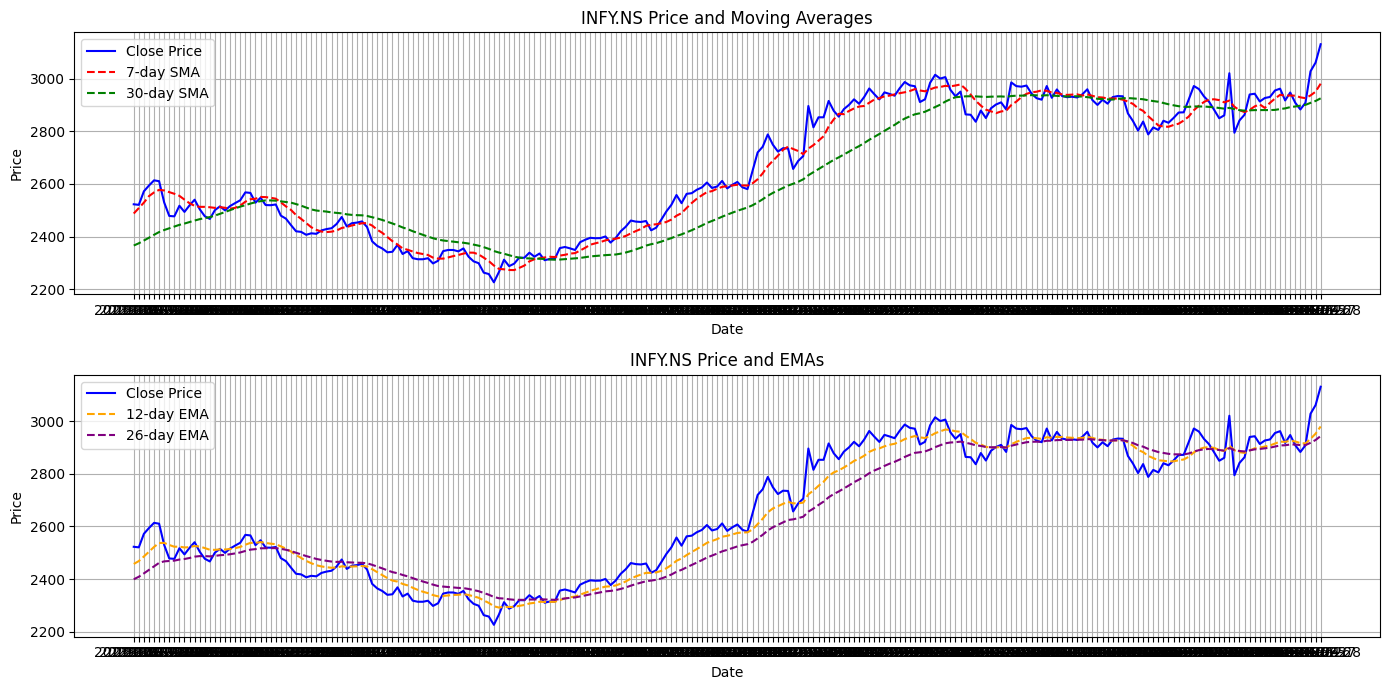

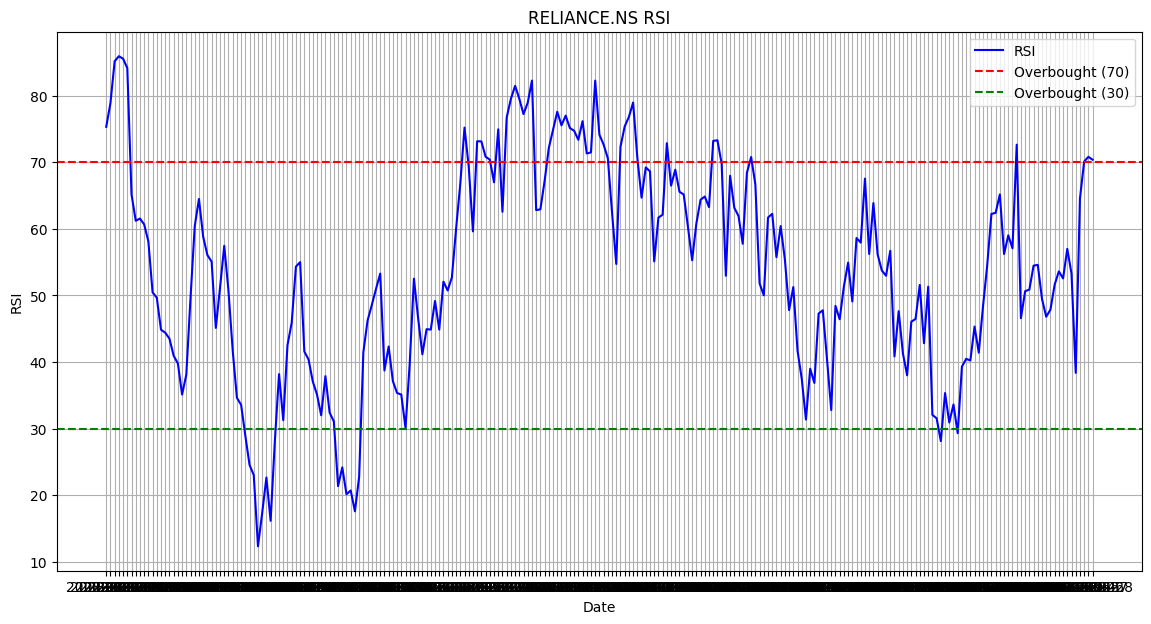

In [35]:
# plot technical indicators for single company stock

stock_ticker = 'RELIANCE.NS'
stock_df_ticker = stock_data[stock_data['Ticker'] == stock_ticker]
plot_technical_indicators(stock_df_ticker, ticker)

def plot_rsi(stock_df_ticker, stock_ticker):
  plt.figure(figsize=(14, 7))
  plt.plot(stock_df_ticker['Date'], stock_df_ticker['RSI'], label='RSI', color='blue')
  plt.axhline(70, color='red', linestyle='--', label='Overbought (70)') # above 70 meaning it is overbought
  plt.axhline(30, color='green', linestyle='--', label='Overbought (30)')  # below 30 meaning it is oversold
  plt.title(f'{stock_ticker} RSI')
  plt.xlabel('Date')
  plt.ylabel('RSI')
  plt.legend()
  plt.grid(True)
  plt.show()


# plot RSI

plot_rsi(stock_df_ticker, stock_ticker)

## LSTM (Long Short Term Memory) MODEL

In [36]:
# prepare LSTM Model

def prepare_data(lstm_df, sequence_length=60):
  lstm_df = lstm_df.groupby('ticker').apply(calculate_technical_indicators).reset_index(drop=True) # reset the index
  lstm_features = lstm_df[['close', '7-day SMA', '30-day SMA', '12-day EMA',
                      '26-day EMA', 'RSI', 'lag_1', 'lag_2', 'lag_5',
                      'lag_10']] # list of features

  lstm_scaler = MinMaxScaler()
  lstm_scaled_data = lstm_scaler.fit_transform(lstm_features)

  X, y = [], []
  for i in range(len(lstm_scaled_data) - sequence_length):
    X.append(lstm_scaled_data[i:i + sequence_length])
    y.append(lstm_scaled_data[i + sequence_length, 0])

  X, y = np.array(X), np.array(y) # convert to numpy array
  return X, y, lstm_scaler

In [37]:
# build LSTM model and train

def build_and_train_lstm(X, y, epochs=10, batch_size=32,
                         learning_rate=0.001): # define the batch_size 32, learning_rate 0.001 and train on 10 spochs
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                      shuffle=False) # train data is 80% and test data is 20%

  lstm_model = Sequential([
      LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],
                                                         X_train.shape[2])),
      Dropout(0.2), # reduce the overfitting problem
      LSTM(units=64, return_sequences=True),
      Dropout(0.2),
      LSTM(units=32), # second layer define without return sequence
      Dropout(0.2),
      Dense(1) # for the output layer
  ])

  lstm_optimizer = Adam(learning_rate=learning_rate)


  # compile model

  lstm_model.compile(optimizer=lstm_optimizer, loss='mean_squared_error')
  print("LSTM Model SUmmary: ", lstm_model.summary())

  history = lstm_model.fit(X_train, y_train, epochs=epochs,
                           batch_size=batch_size, validation_split=0.1,
                           verbose=1)


  # evaluate the model

  lstm_predictions = lstm_model.predict(X_test)
  return lstm_model, history, lstm_predictions, y_test


# preparing data for each stock

sequence_length = 60
X, y, scaler = prepare_data(stock_data, sequence_length)


# build LSTM model and training

learning_rate = 0.001
lstm_model, history, lstm_predictions, y_test = build_and_train_lstm( X, y,
                                                                     learning_rate=learning_rate)


# save the model

lstm_model.save('/content/drive/MyDrive/Project/lstm_stock_model.h5')


# normalise the prediction values

lstm_scaler_y = MinMaxScaler(feature_range=(0, 1))
lstm_y_test_scaled = lstm_scaler_y.fit_transform(y_test.reshape(-1, 1)) # reshape the value
lstm_predictions_scaled = lstm_scaler_y.transform(lstm_predictions)


# calculate performace metrics

lstm_mse = mean_squared_error(lstm_y_test_scaled, lstm_predictions_scaled)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(lstm_y_test_scaled, lstm_predictions_scaled)


# print 3 metrics

print(f'LSTM MSE: {lstm_mse}')
print(f'LSTM RMSE: {lstm_rmse}')
print(f'LSTM MAE: {lstm_mae}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 60, 64)              │          19,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 60, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,673 (252.63 KB)

 Trainable params: 64,673 (252.63 KB)

 Non-trainable params: 0 (0.00 B)

LSTM Model SUmmary:  None
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0128 - val_loss: 0.0015
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0049 - val_loss: 0.0014
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - val_loss: 6.6688e-04
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0025 - val_loss: 6.2055e-04
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020 - val_loss: 8.3490e-04
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0029 - val_loss: 6.8393e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


LSTM MSE: 0.0036365645215128144
LSTM RMSE: 0.06030393454421373
LSTM MAE: 0.022476226801772865


LSTM Result Plots

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


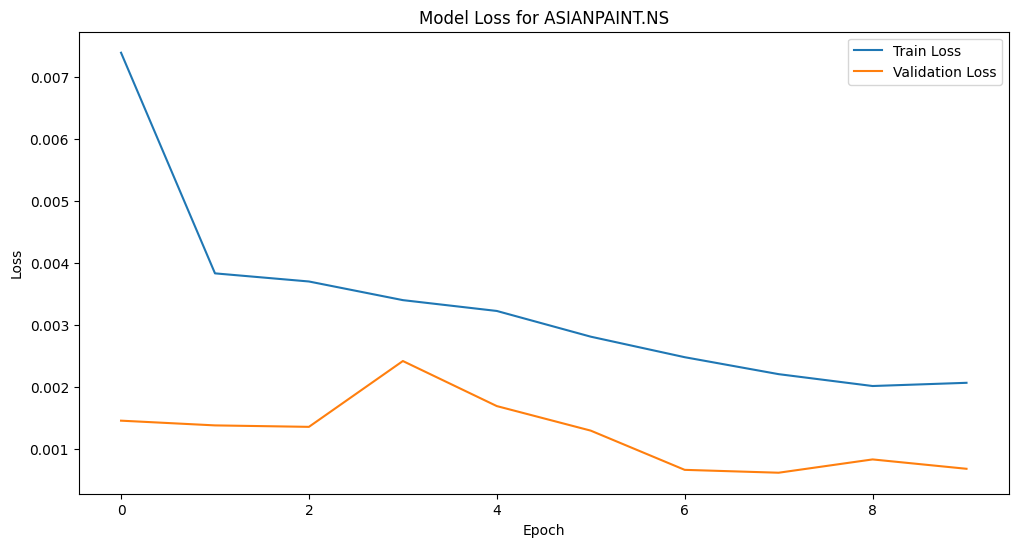

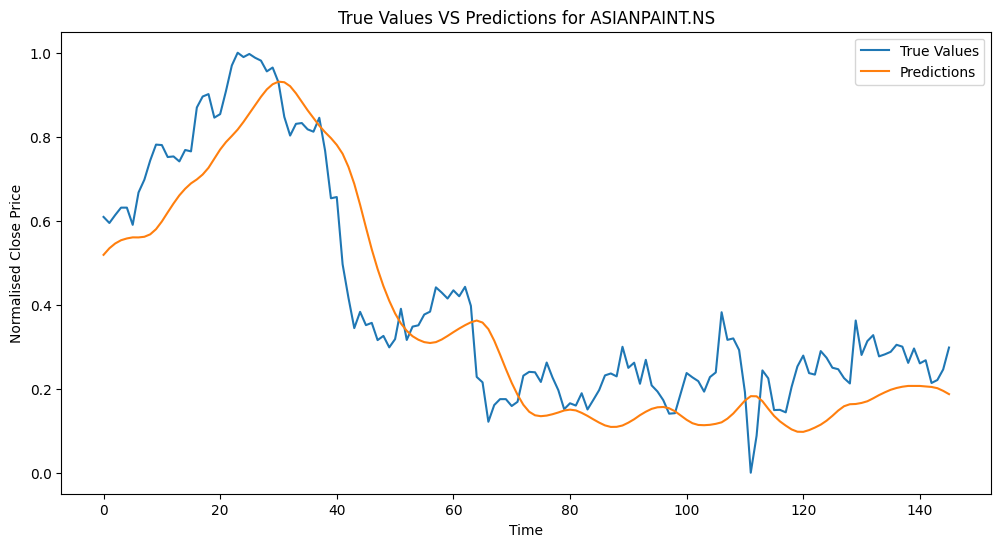

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


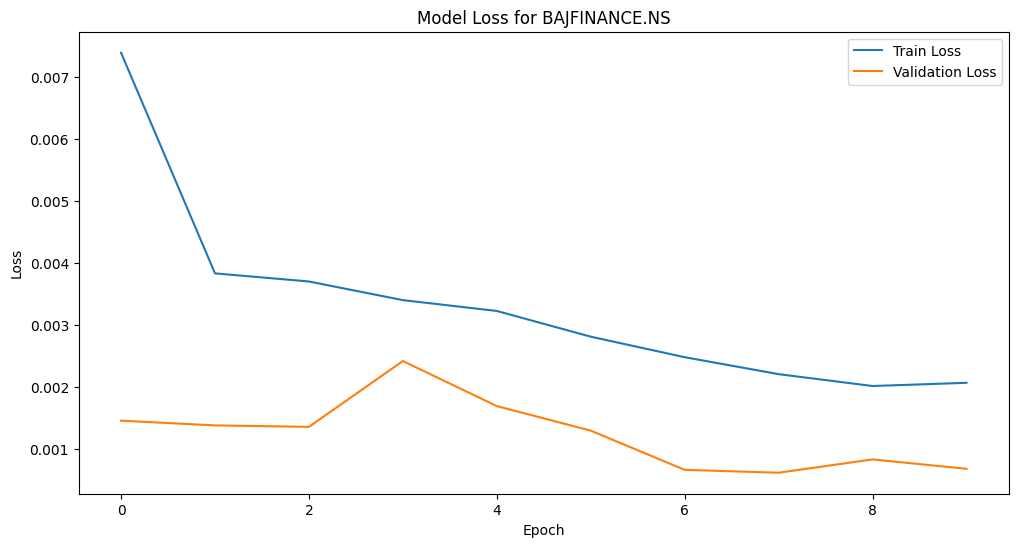

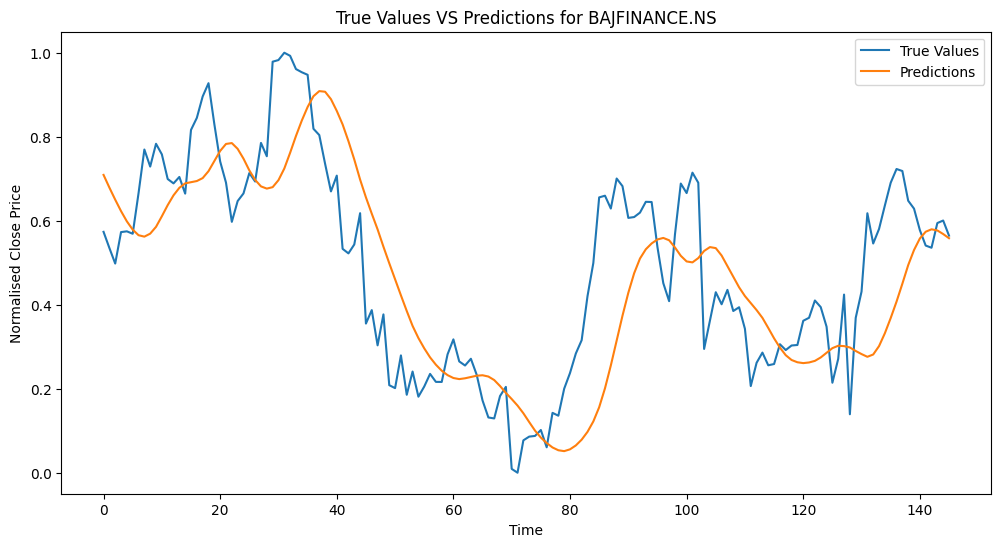

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


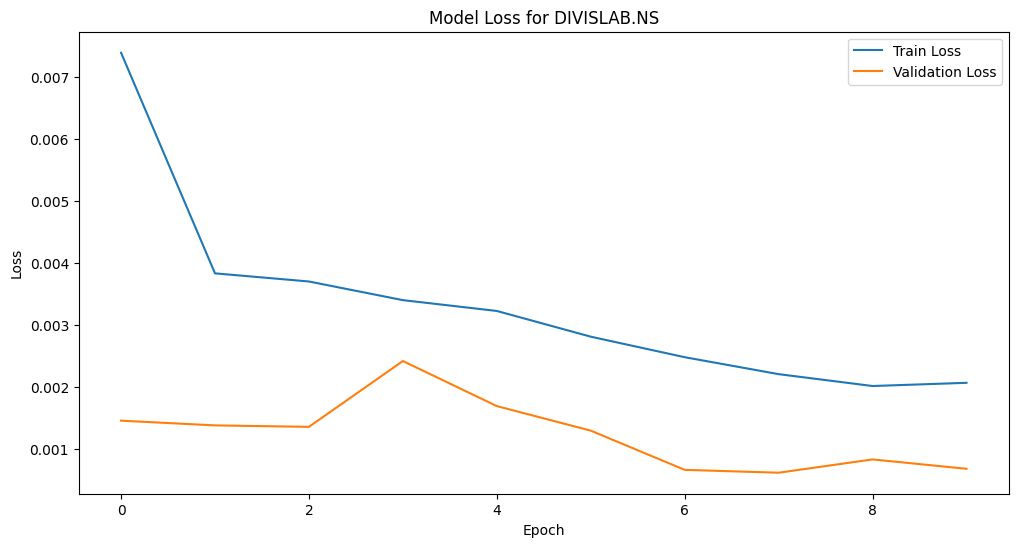

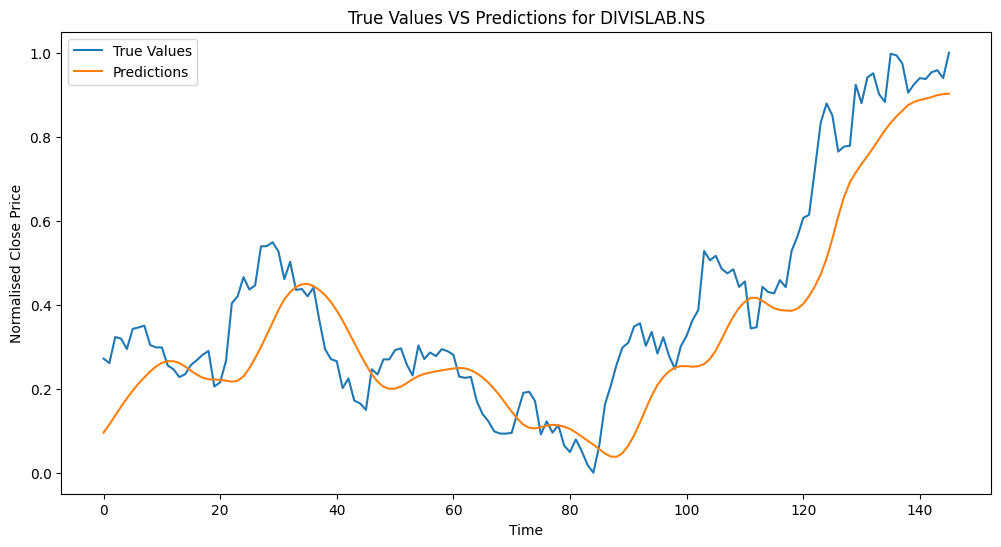

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


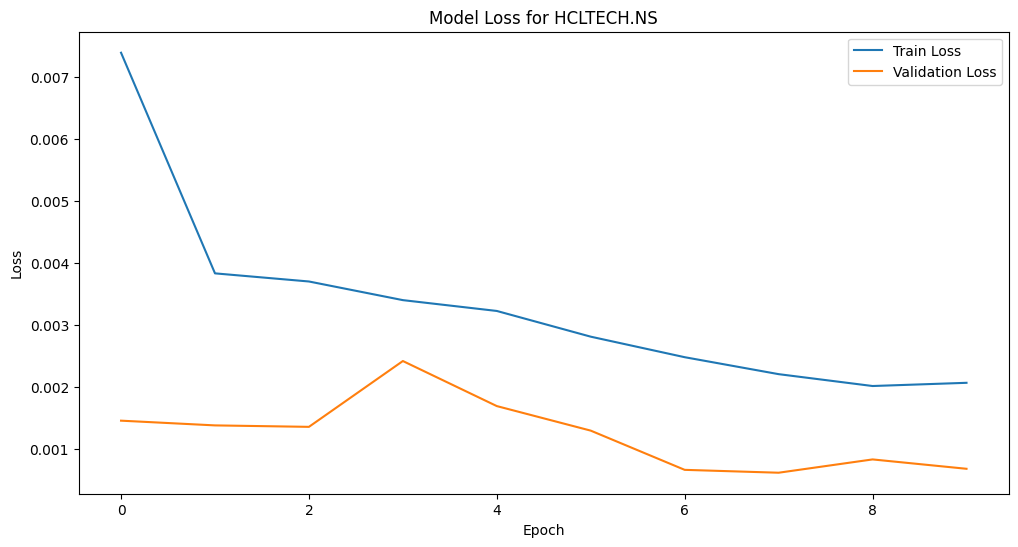

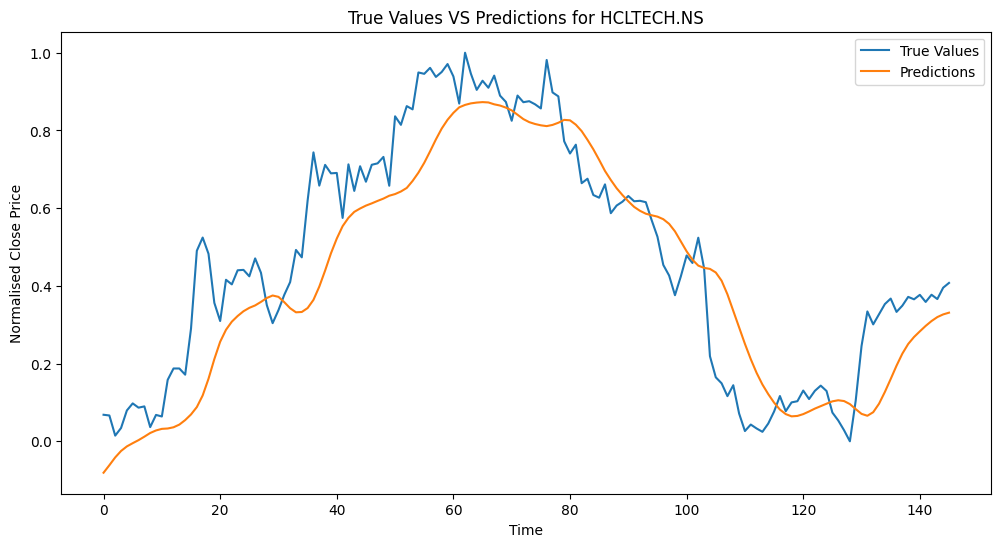

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


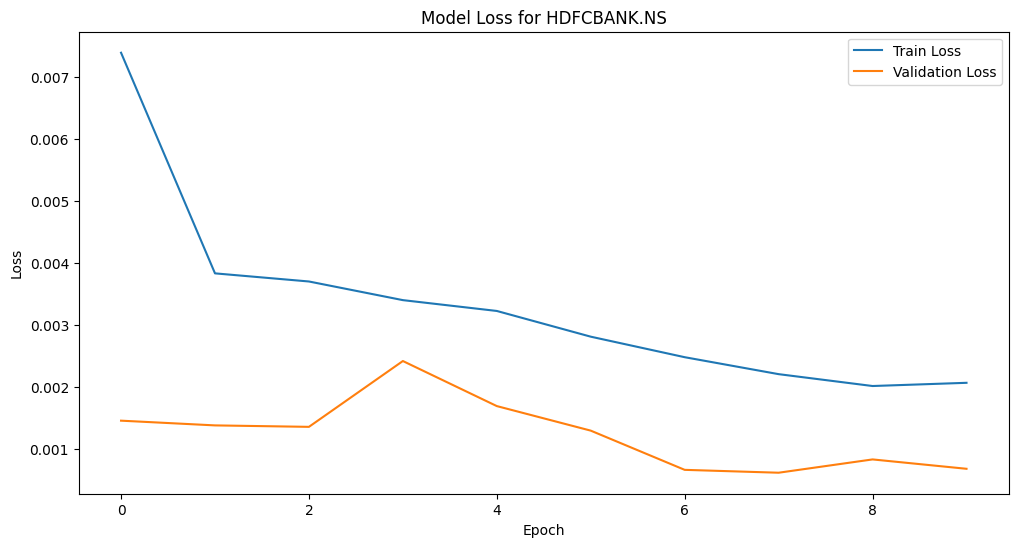

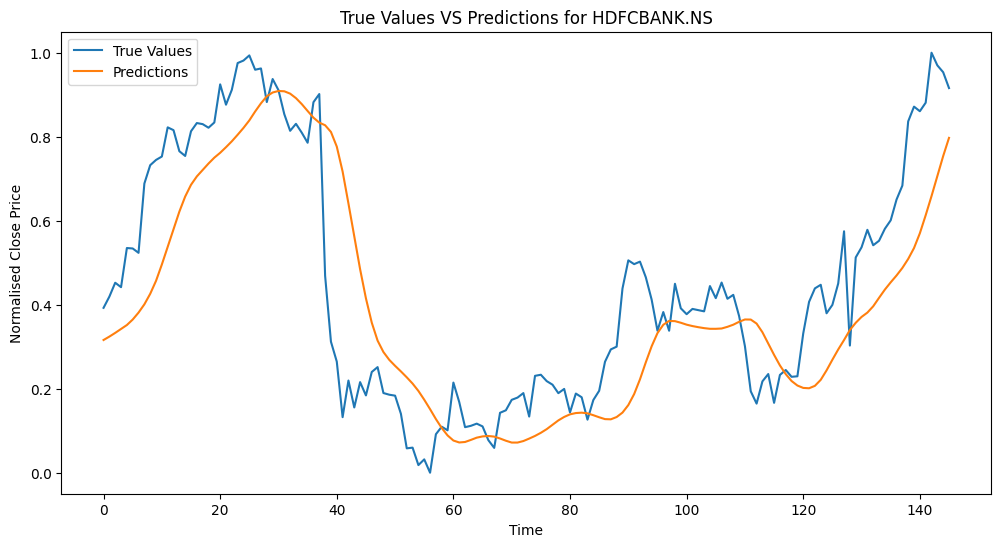

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


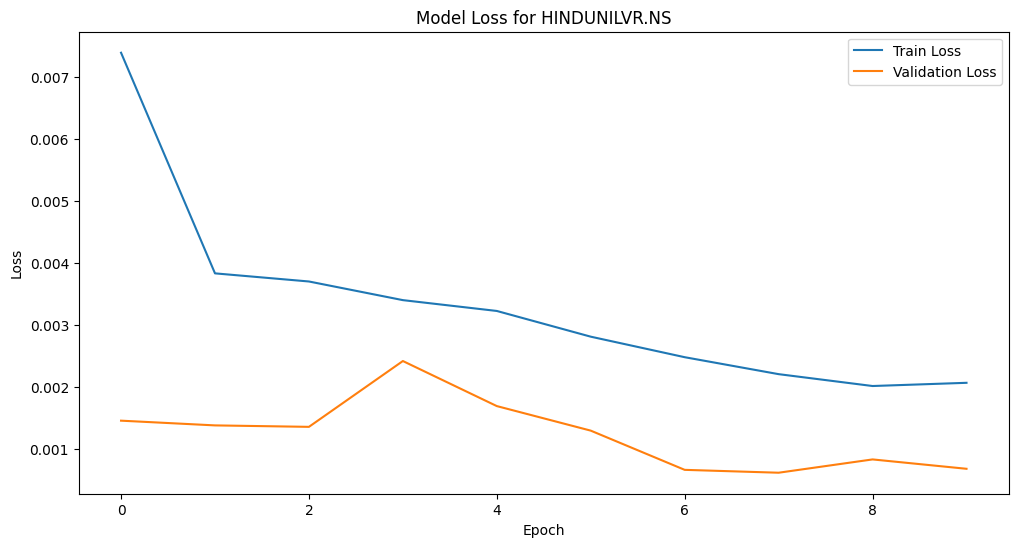

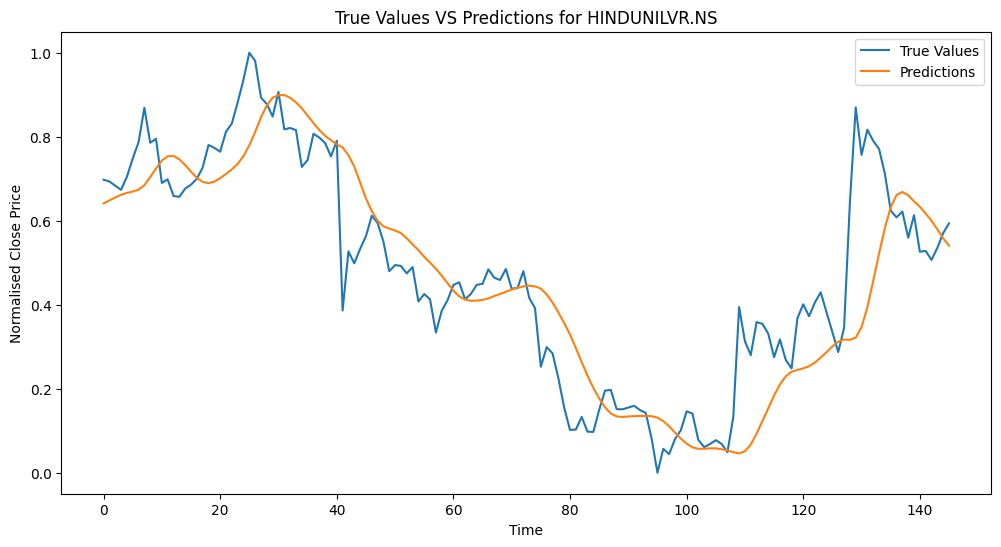

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


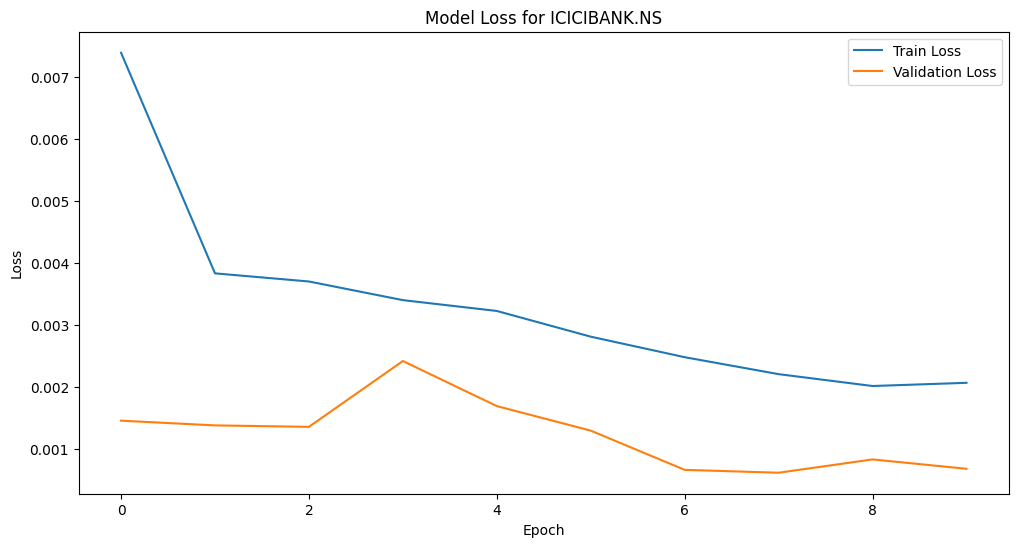

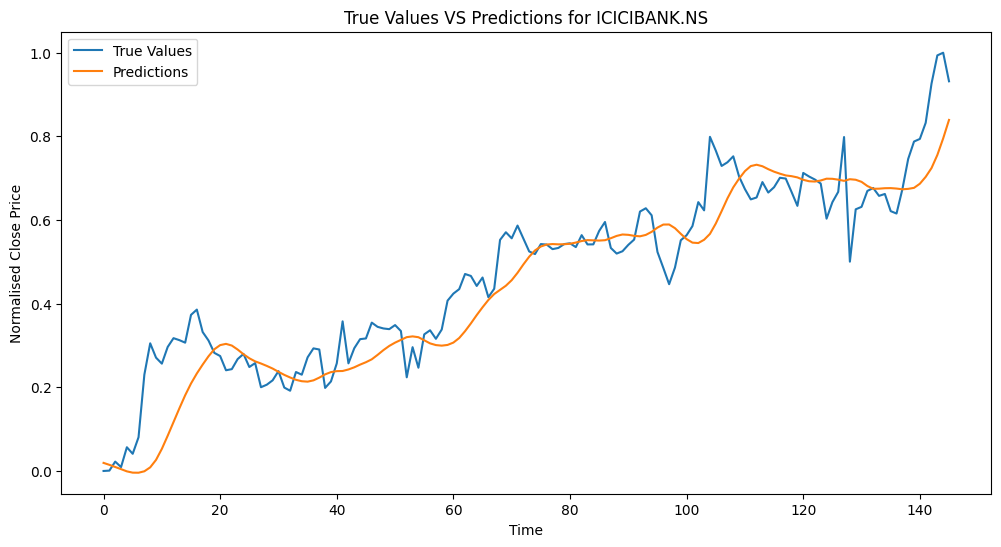

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


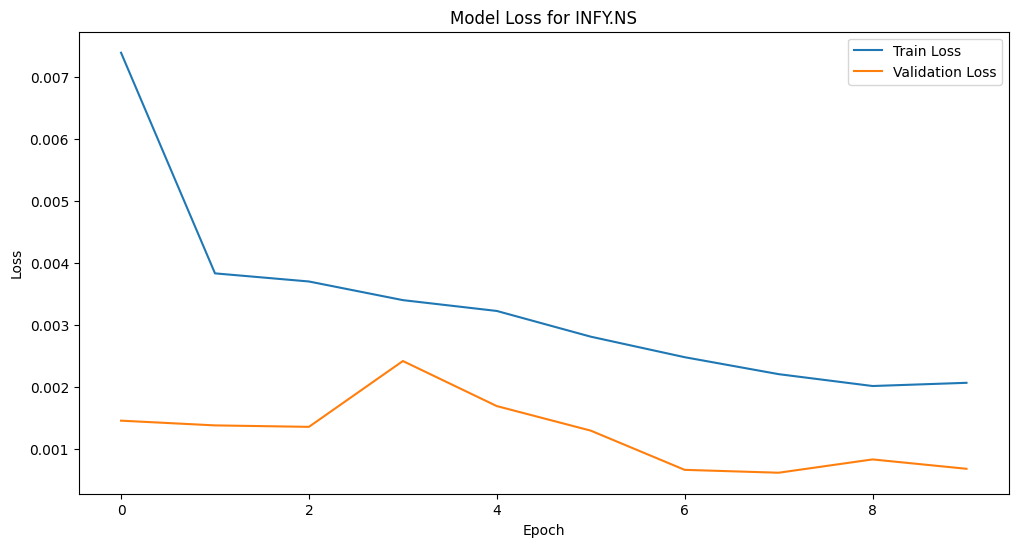

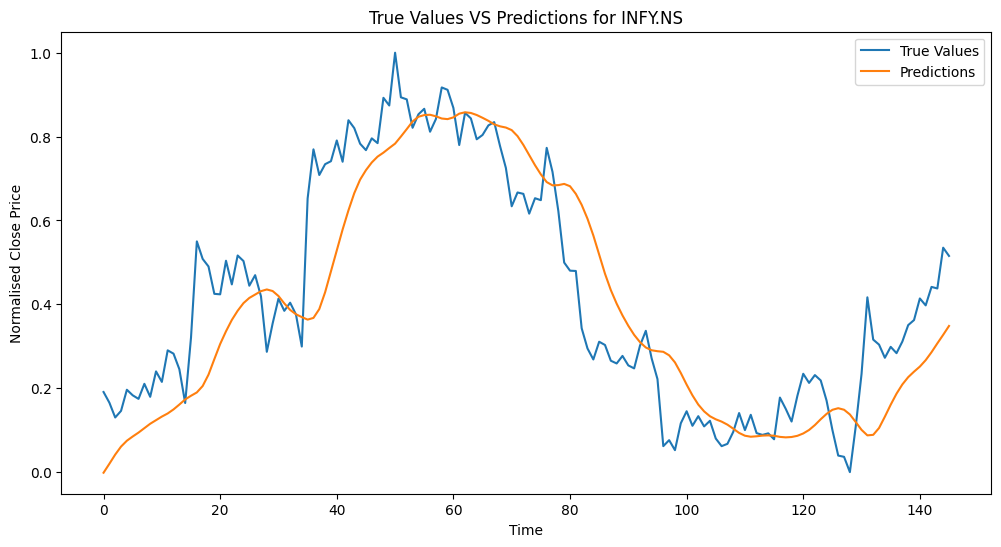

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


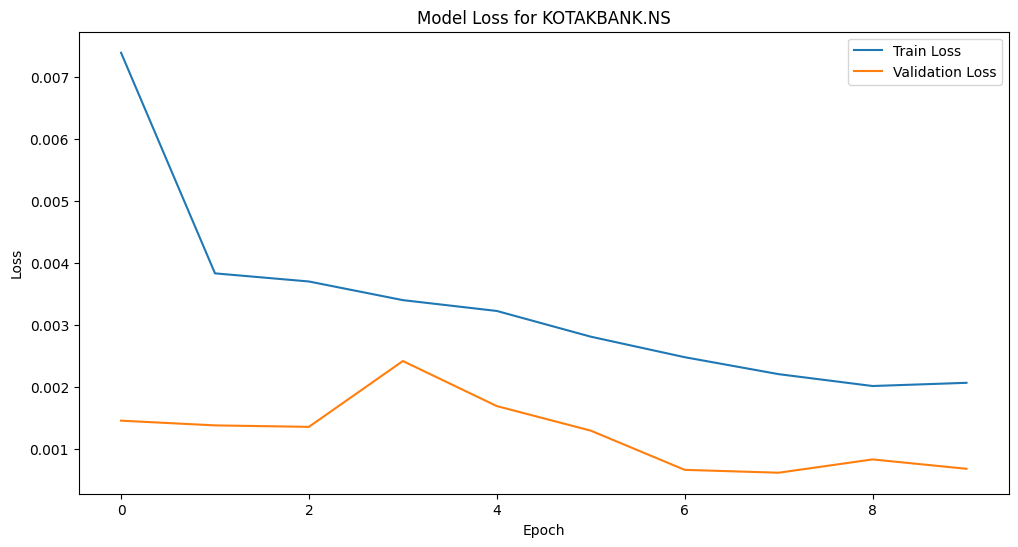

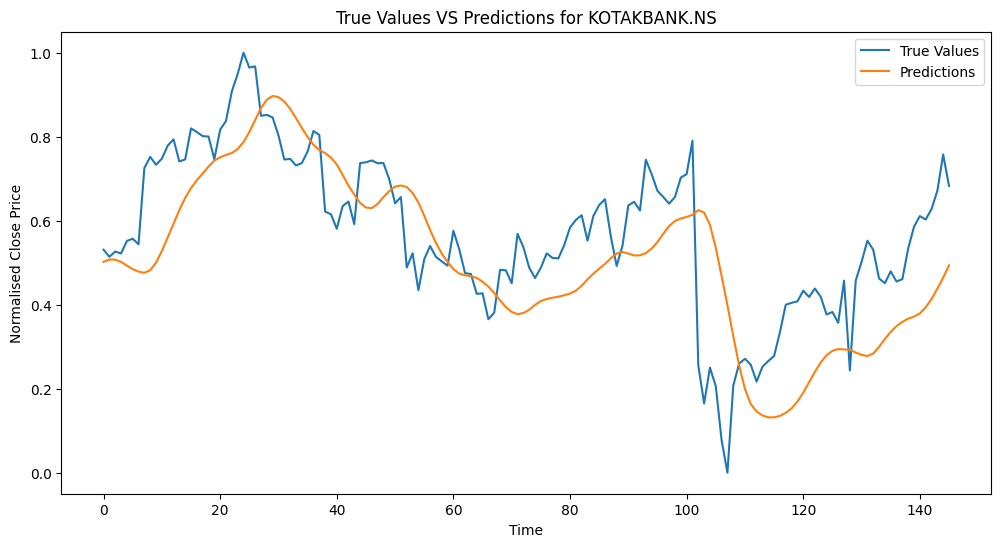

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


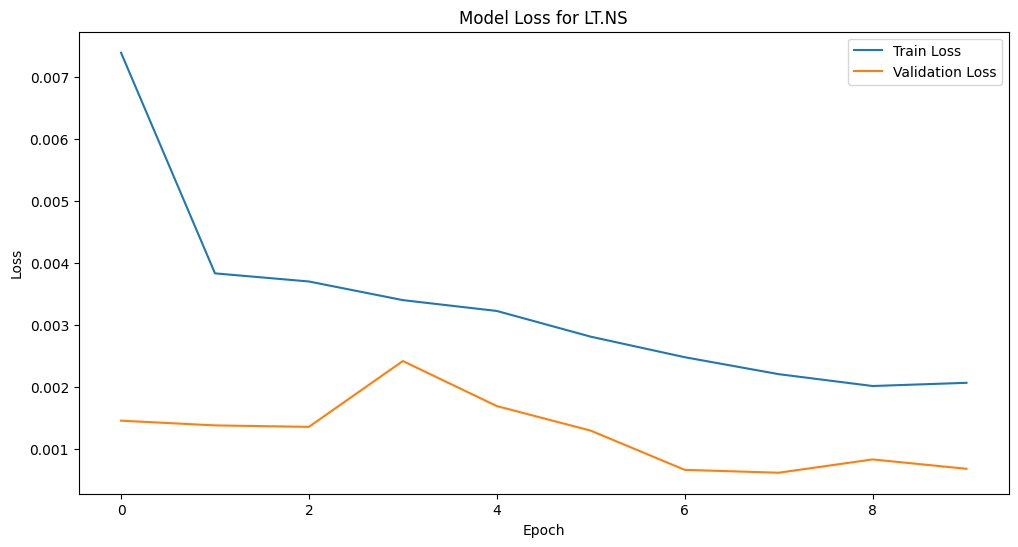

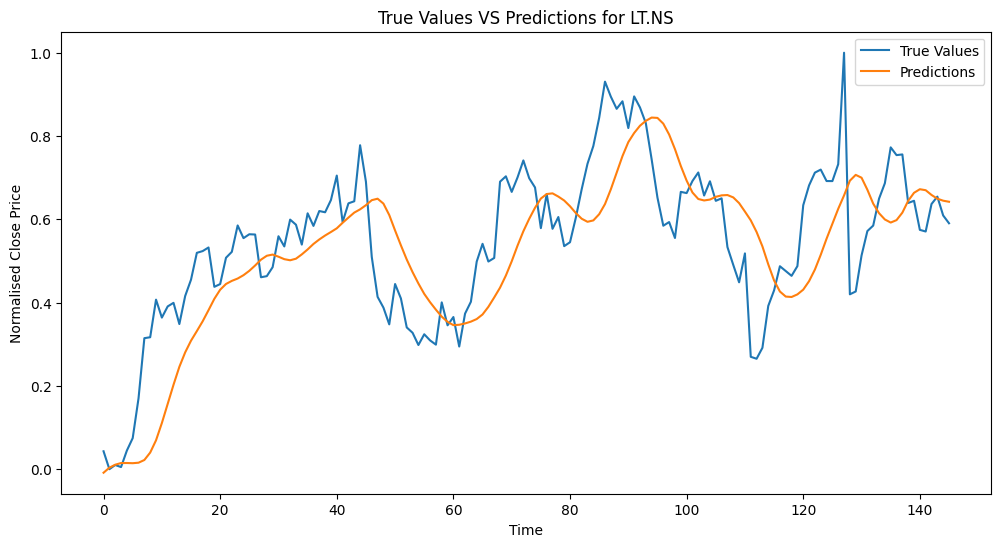

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


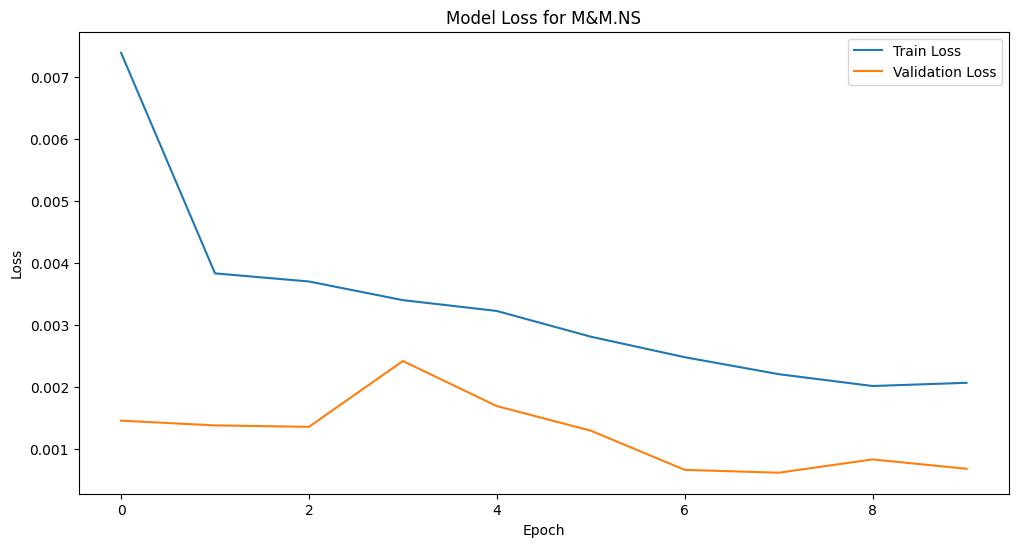

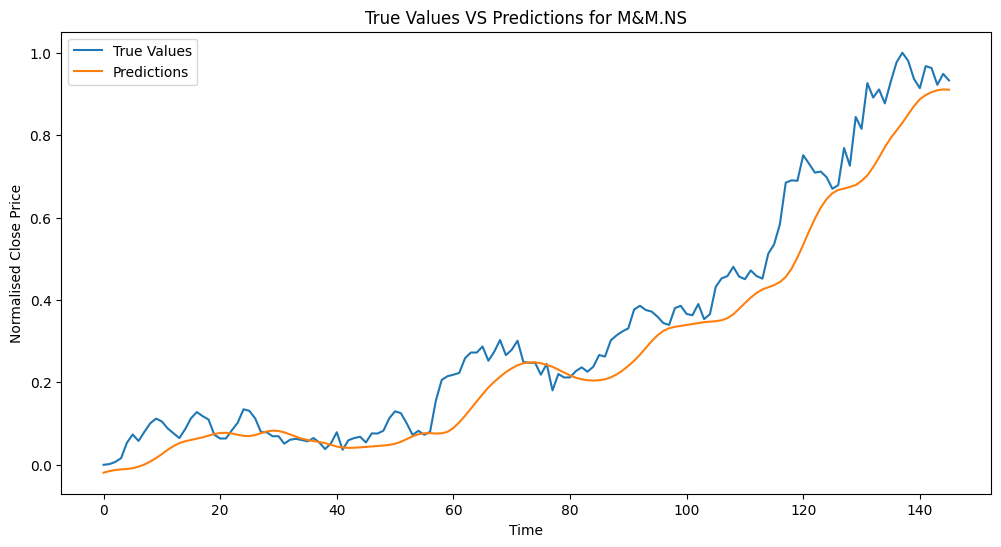

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


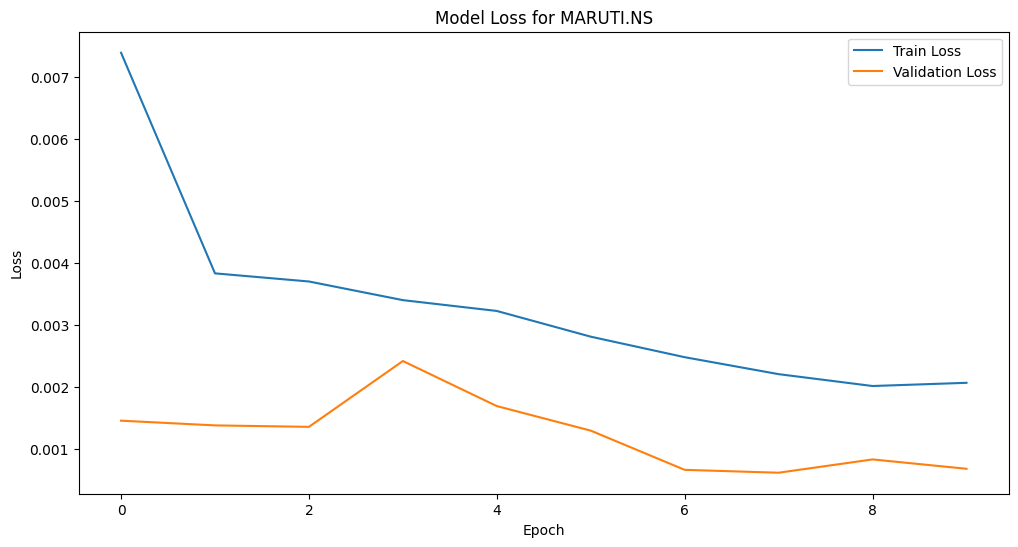

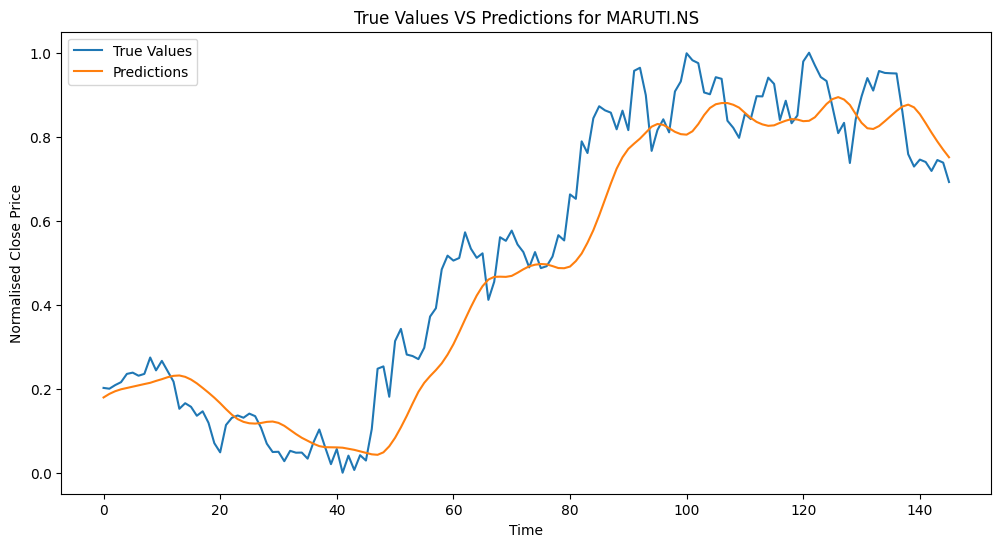

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


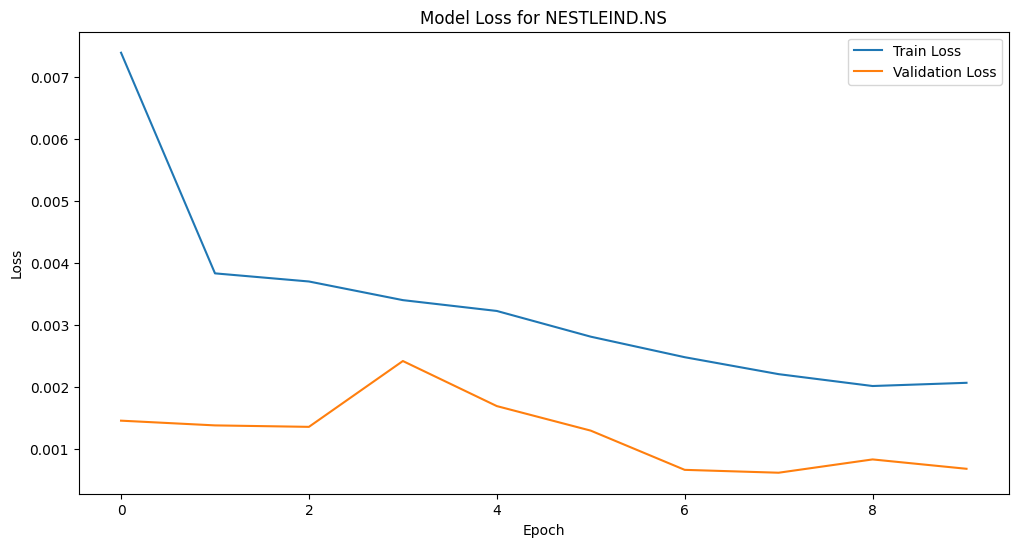

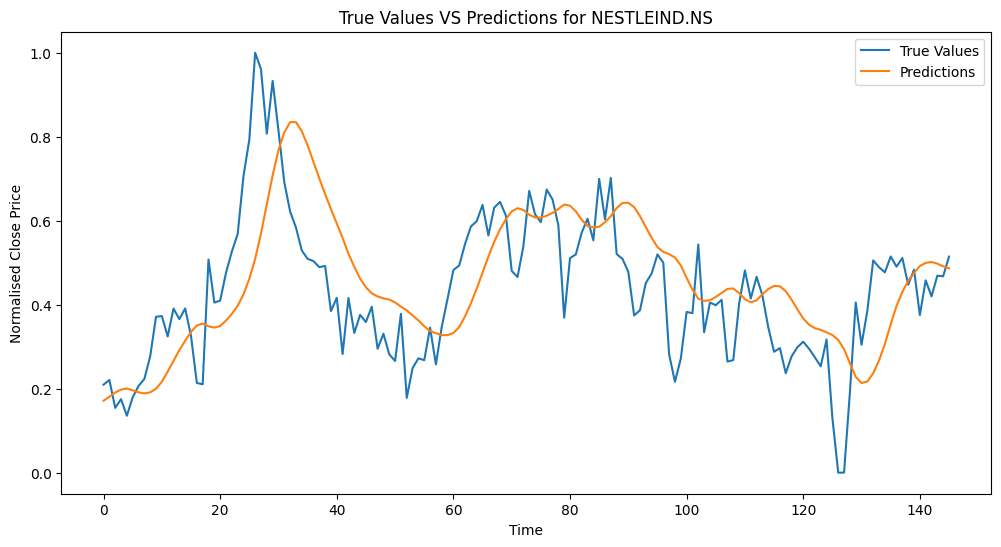

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


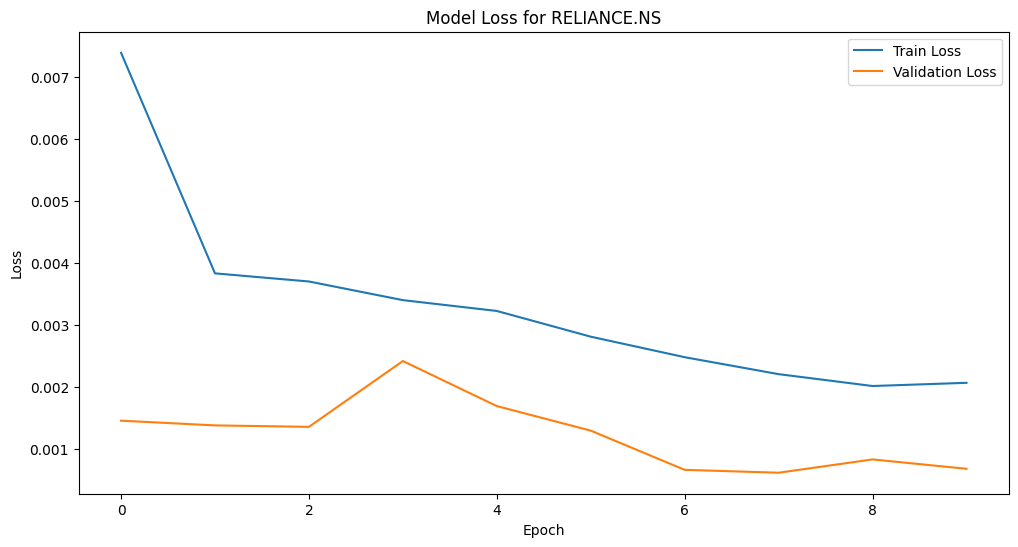

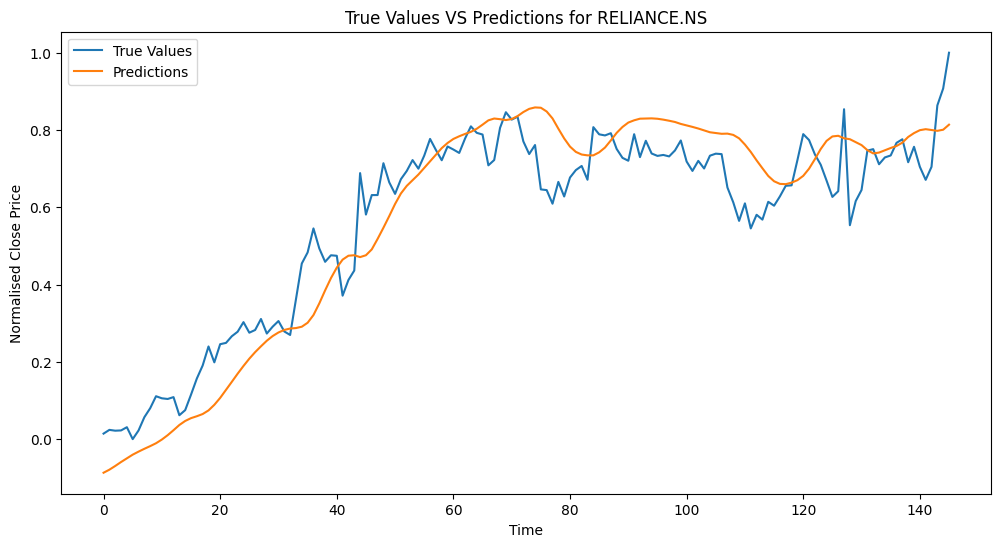

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


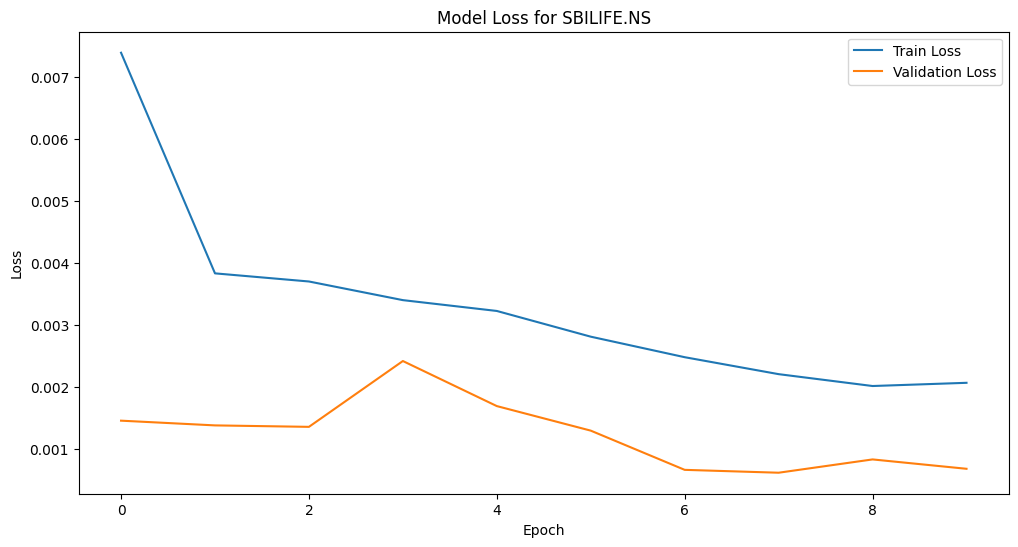

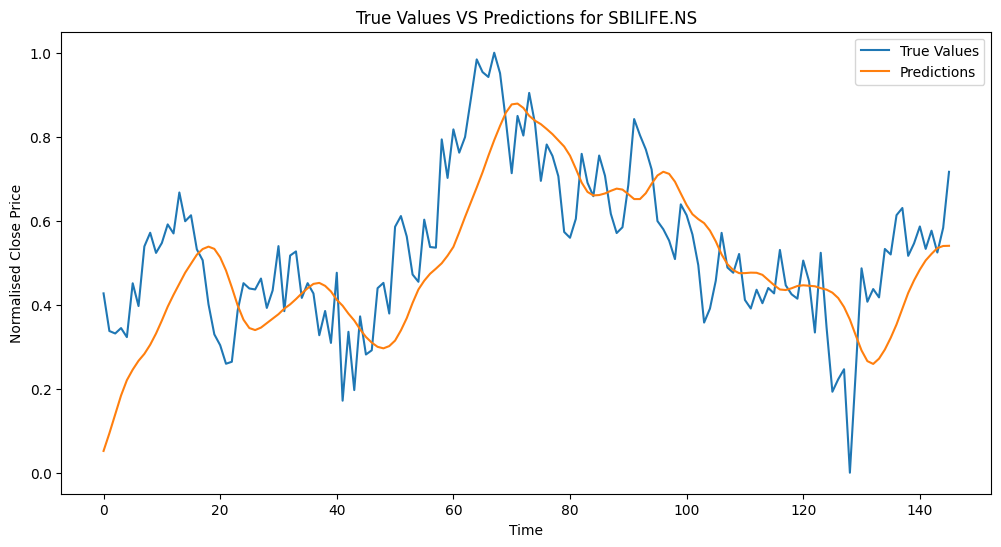

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


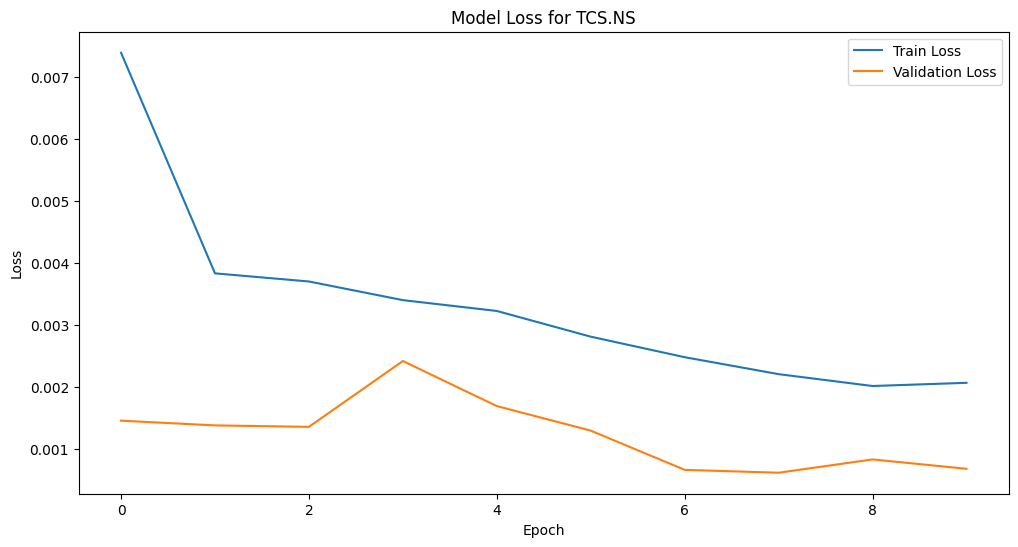

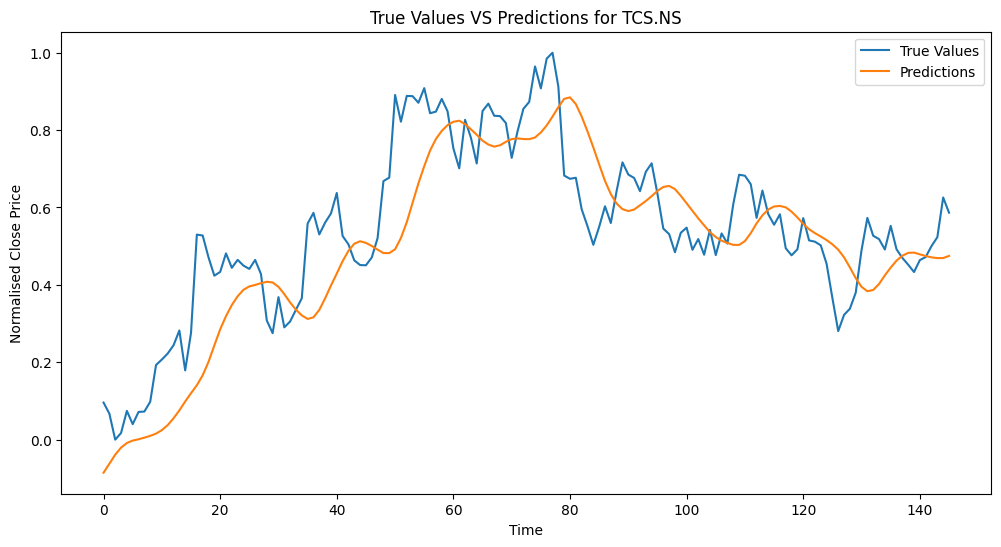

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


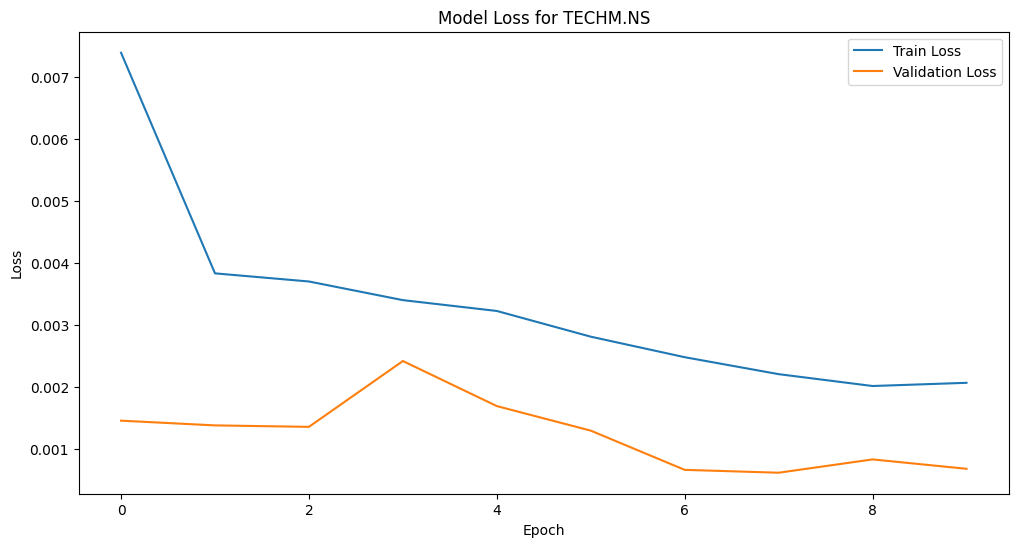

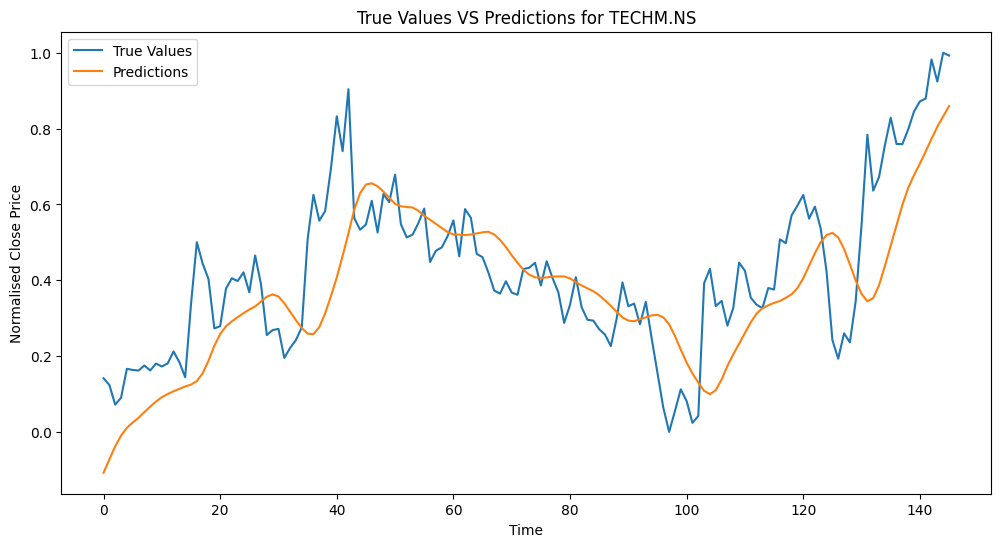

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


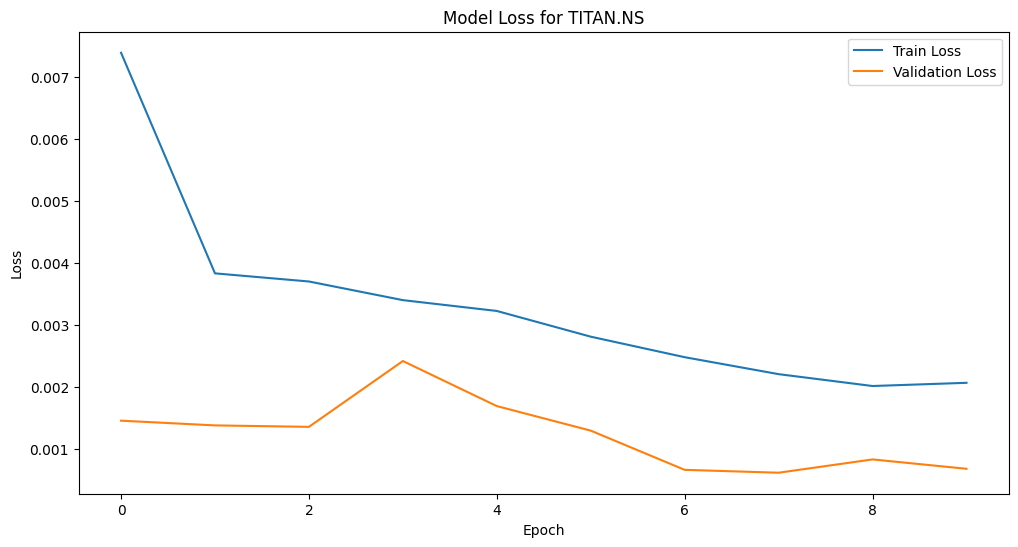

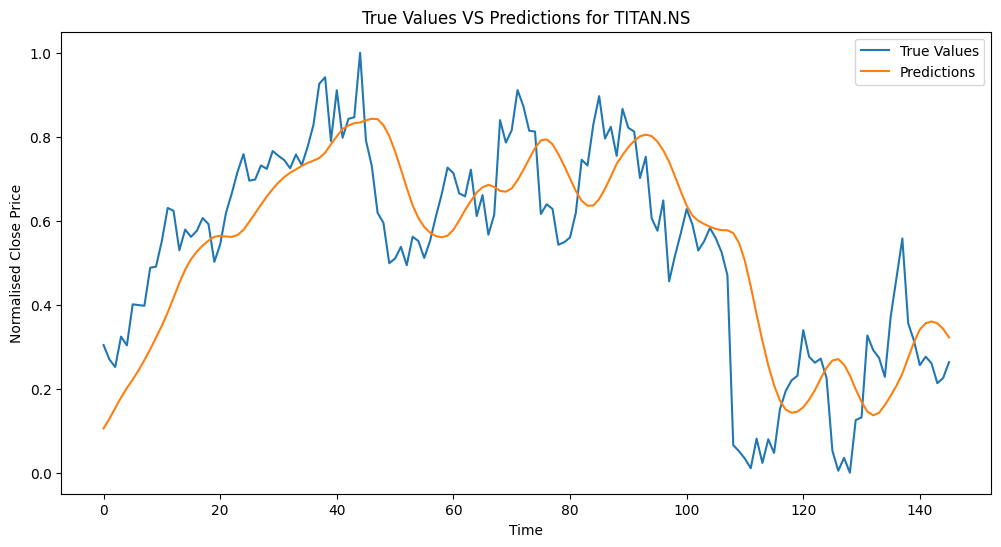

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


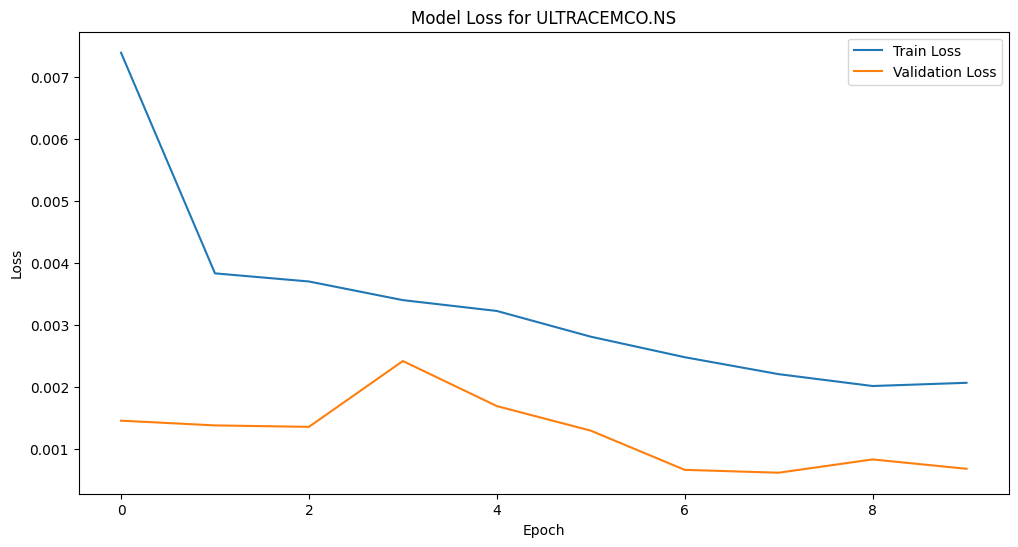

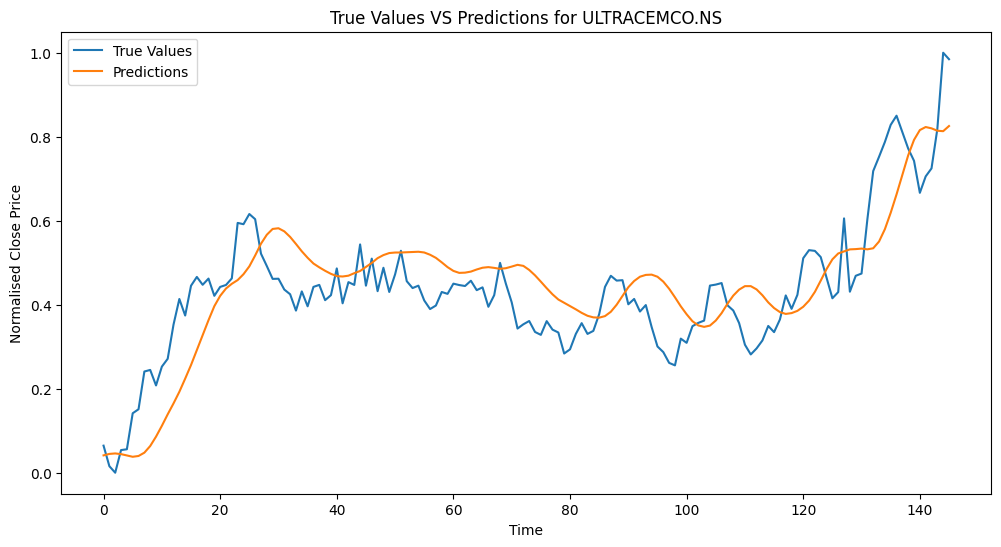

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


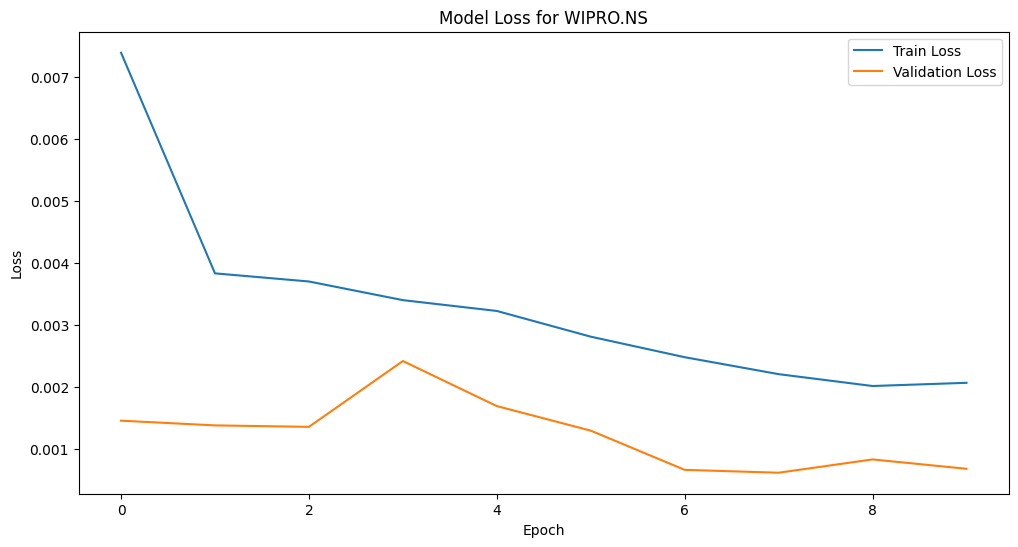

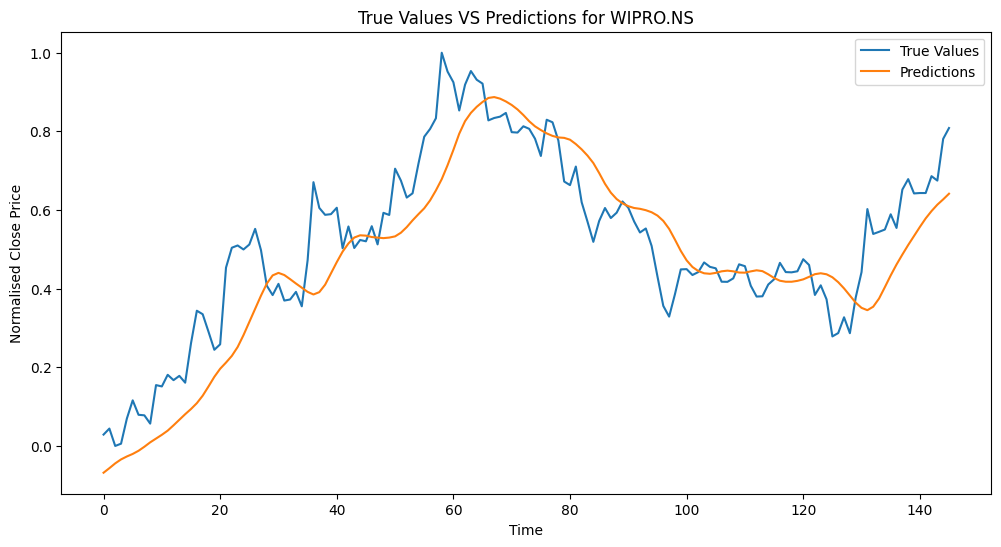

           Ticker       MSE      RMSE       MAE
0   ASIANPAINT.NS  0.101762  0.119566  0.022476
1   BAJFINANCE.NS  0.135710  0.169917  0.022476
2     DIVISLAB.NS  0.100595  0.127244  0.022476
3      HCLTECH.NS  0.110236  0.138820  0.022476
4     HDFCBANK.NS  0.136733  0.174713  0.022476
5   HINDUNILVR.NS  0.093793  0.132695  0.022476
6    ICICIBANK.NS  0.064547  0.089035  0.022476
7         INFY.NS  0.110288  0.139594  0.022476
8    KOTAKBANK.NS  0.127908  0.154681  0.022476
9           LT.NS  0.113774  0.141870  0.022476
10         M&M.NS  0.061323  0.081350  0.022476
11      MARUTI.NS  0.081158  0.104391  0.022476
12   NESTLEIND.NS  0.117796  0.147646  0.022476
13    RELIANCE.NS  0.081176  0.098205  0.022476
14     SBILIFE.NS  0.119501  0.146089  0.022476
15         TCS.NS  0.108982  0.136697  0.022476
16       TECHM.NS  0.129272  0.161837  0.022476
17       TITAN.NS  0.125141  0.157216  0.022476
18  ULTRACEMCO.NS  0.085389  0.101345  0.022476
19       WIPRO.NS  0.093468  0.117503  0

In [38]:
# plot results for each stock

def plot_results_for_each_stock(data, model, sequence_length=60):
  tickers = stock_data['ticker'].unique()
  lstm_results = [] # store result for each stock

  for ticker in tickers:
    ticker_data = stock_data[stock_data['ticker'] == ticker] # fit the data
    if ticker_data.shape[0] <= sequence_length:
      print(f"Not Enough Data for {ticker}. Skipping...")
      continue


    # prepare data for current selected company

    X, y, scaler = prepare_data(ticker_data, sequence_length)


    # prediction for each stock

    lstm_predictions = lstm_model.predict(X)


    # Normalise the prediction values
    lstm_scaler_y = MinMaxScaler(feature_range=(0, 1))
    y = np.concatenate([y, y[-len(lstm_predictions):]]) # append to match the prediction length
    lstm_y_scaled = lstm_scaler_y.fit_transform(y.reshape(-1, 1)) # reshape
    lstm_predictions_scaled = lstm_scaler_y.transform(lstm_predictions)


    # calculate performance metrics

    lstm_mse = mean_squared_error(lstm_y_scaled[-len(lstm_predictions):],
                                    lstm_predictions_scaled)
    lstm_rmse = np.sqrt(lstm_mse)
    lstm_mse = mean_absolute_error(lstm_y_scaled[-len(lstm_predictions):],
                                    lstm_predictions_scaled)


    # store performance metrics for each stock

    lstm_results.append({
        'Ticker': ticker,
        'MSE': lstm_mse,
        'RMSE': lstm_rmse,
        'MAE': lstm_mae
    })


    # plot training & validation loss curves

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss for {ticker}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    # plot True Vs Predicted Price curve

    plt.figure(figsize=(12, 6))
    plt.plot(lstm_y_scaled[-len(lstm_predictions):], label='True Values')
    plt.plot(lstm_predictions_scaled, label='Predictions')
    plt.title(f'True Values VS Predictions for {ticker}')
    plt.xlabel('Time')
    plt.ylabel('Normalised Close Price')
    plt.legend()
    plt.show()

  # converting results into DataFrame
  lstm_results_df = pd.DataFrame(lstm_results)
  print(lstm_results_df)


  # calculate Average of all stocks

  lstm_average_metrics = lstm_results_df[['MSE', 'RMSE', 'MAE']].mean()
  print('Average LSTM Metrics Across All Stocks: ')
  print(lstm_average_metrics)


# plot results for each stock

plot_results_for_each_stock(stock_data, lstm_model, sequence_length=60)

## GRU (Gated Recurrent Unit) Model

In [42]:
# prepare data for FRU

def prepare_data(gru_df, sequence_length=60):
  gru_df = gru_df.groupby('ticker').apply(calculate_technical_indicators).reset_index(drop=True) # using groupby function we apply for whole dataset
  gru_features = gru_df[['close', '7-day SMA', '30-day SMA', '12-day EMA',
                      '26-day EMA', 'RSI', 'lag_1', 'lag_2', 'lag_5',
                      'lag_10']] # list of features


  gru_scaler = MinMaxScaler()
  gru_scaled_data = gru_scaler.fit_transform(gru_features)

  X, y = [], []
  for i in range(len(gru_scaled_data) - sequence_length):
    X.append(gru_scaled_data[i:i + sequence_length])
    y.append(gru_scaled_data[i + sequence_length, 0])

  X, y = np.array(X), np.array(y) # convert to numpy array
  return X, y, gru_scaler


In [43]:
# build LSTM model and train

def build_and_train_gru(X, y, epochs=10, batch_size=32,
                         learning_rate=0.001): # define the batch_size 32, learning_rate 0.001 and train on 10 spochs
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                      shuffle=False) # train data is 80% and test data is 20%

  gru_model = Sequential([
      GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],
                                                        X_train.shape[2])),
      GRU(units=50), # second layer
      Dense(1) # output layer
  ])

  gru_optimizer = Adam(learning_rate=learning_rate)


  # compile model

  gru_model.compile(optimizer=gru_optimizer, loss='mean_squared_error')
  print("GRU Model SUmmary: ", gru_model.summary())

  history = gru_model.fit(X_train, y_train, epochs=epochs,
                           batch_size=batch_size, validation_split=0.1,
                           verbose=1)


  # evaluate the model

  gru_predictions = gru_model.predict(X_test)
  return gru_model, history, gru_predictions, y_test


# preparing data for each stock

sequence_length = 60
X, y, scaler = prepare_data(stock_data, sequence_length)


# build GRU model and training

learning_rate = 0.001
gru_model, history, gru_predictions, y_test = build_and_train_gru( X, y,
                                                                     learning_rate=learning_rate)


# save the model

gru_model.save('/content/drive/MyDrive/Project/lstm_stock_model.h5')


# normalise the prediction values

gru_scaler_y = MinMaxScaler(feature_range=(0, 1))
gru_y_test_scaled = gru_scaler_y.fit_transform(y_test.reshape(-1, 1)) # reshape the value
gru_predictions_scaled = gru_scaler_y.transform(gru_predictions)


# calculate performace metrics

gru_mse = mean_squared_error(gru_y_test_scaled, gru_predictions_scaled)
gru_rmse = np.sqrt(gru_mse)
gru_mae = mean_absolute_error(gru_y_test_scaled, gru_predictions_scaled)


# print 3 metrics

print(f'GRU MSE: {gru_mse}')
print(f'GRU RMSE: {gru_rmse}')
print(f'GRU MAE: {gru_mae}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ (None, 60, 50)              │           9,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,651 (96.29 KB)

 Trainable params: 24,651 (96.29 KB)

 Non-trainable params: 0 (0.00 B)

GRU Model SUmmary:  None
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0283 - val_loss: 4.7268e-04
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.1814e-04 - val_loss: 3.7775e-04
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.4516e-04 - val_loss: 3.6644e-04
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.7579e-04 - val_loss: 3.0740e-04
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.0289e-04 - val_loss: 3.1986e-04
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4356e-04 - val_loss: 4.7706e-04
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.6953e-04 - val_loss: 2.6419e-04
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.9668e-04 - val_loss: 2.5351e-04
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5905e-04 - val_loss: 3.6122e-04
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.4531e-04 - val_loss: 2.4677e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


GRU MSE: 0.0015133789758353519
GRU RMSE: 0.03890217186527446
GRU MAE: 0.008053846271775071


GRU Result Plots

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


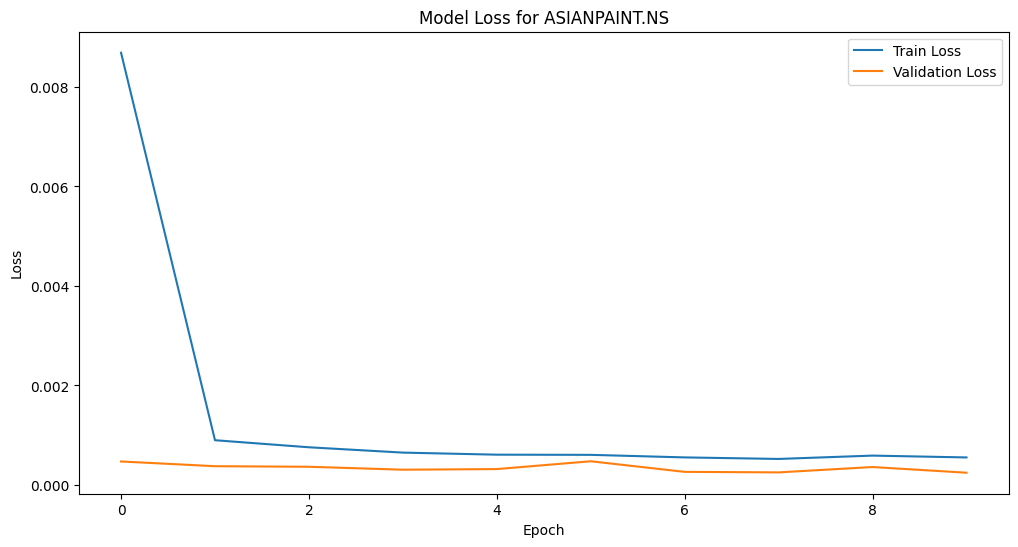

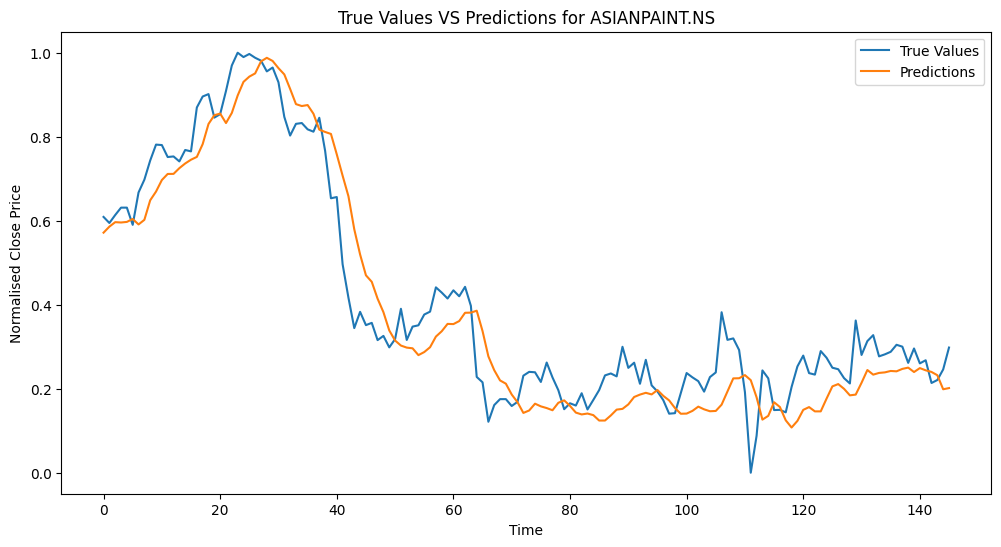

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


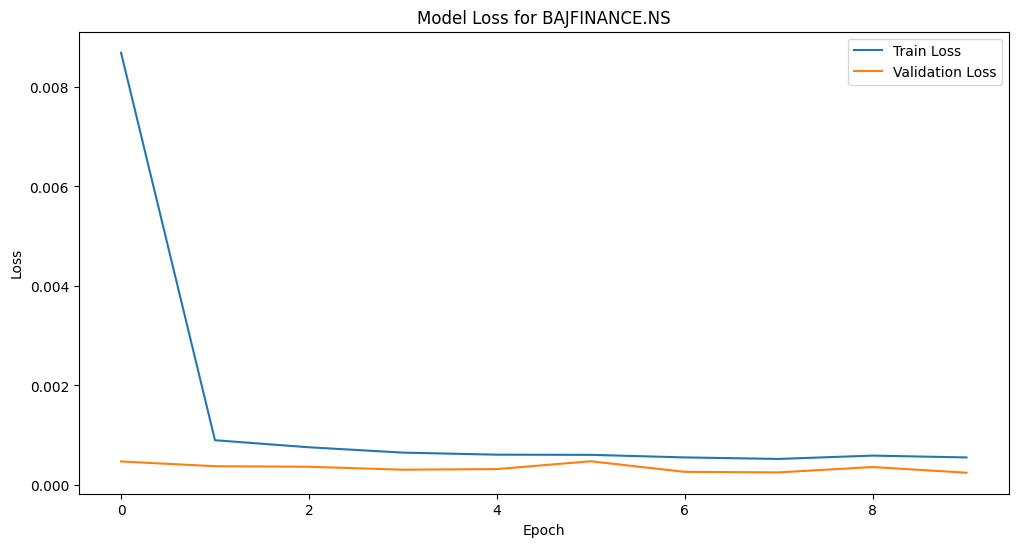

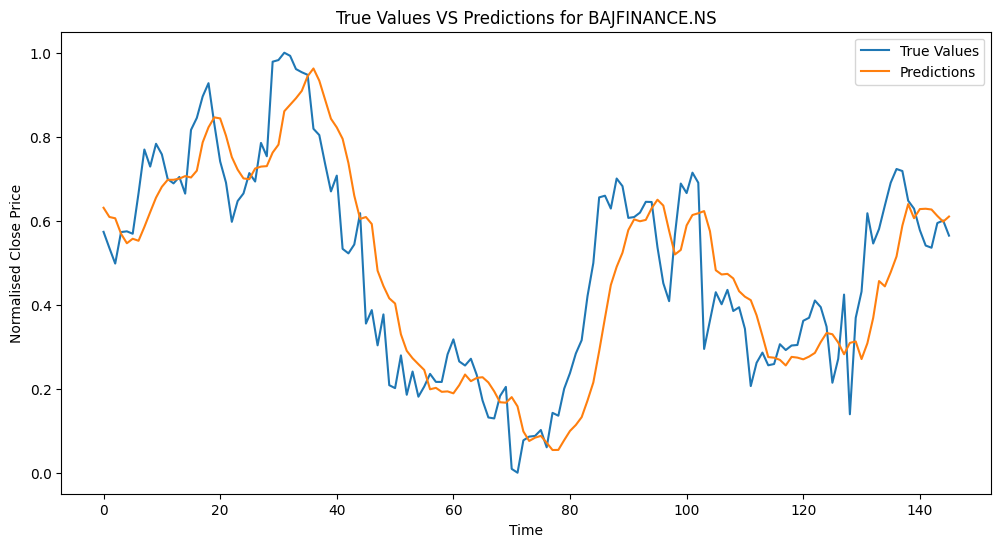

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


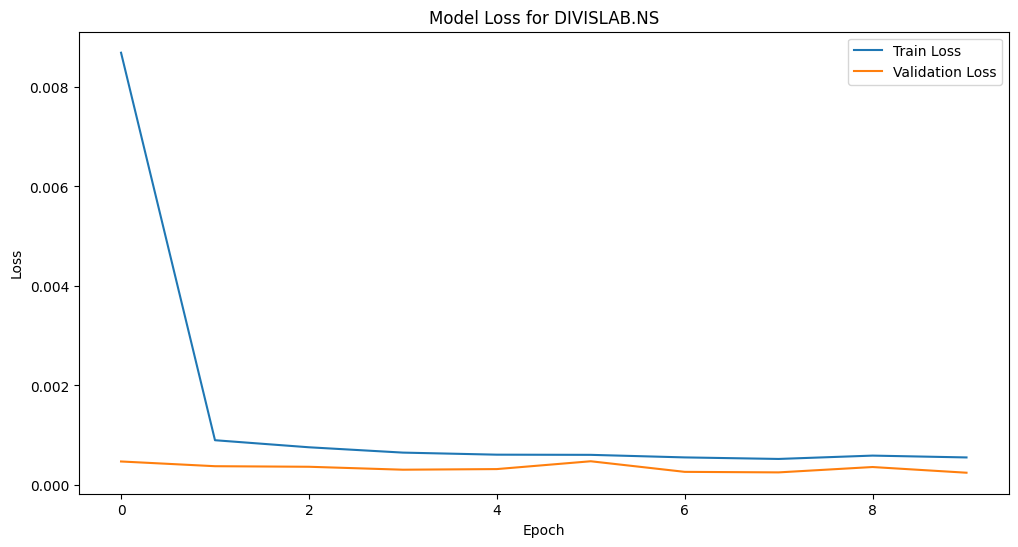

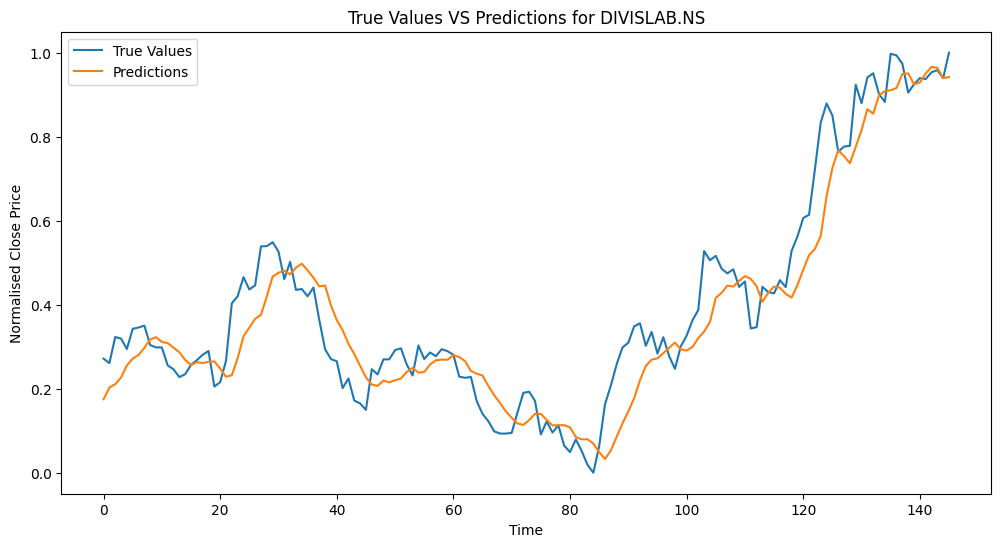

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


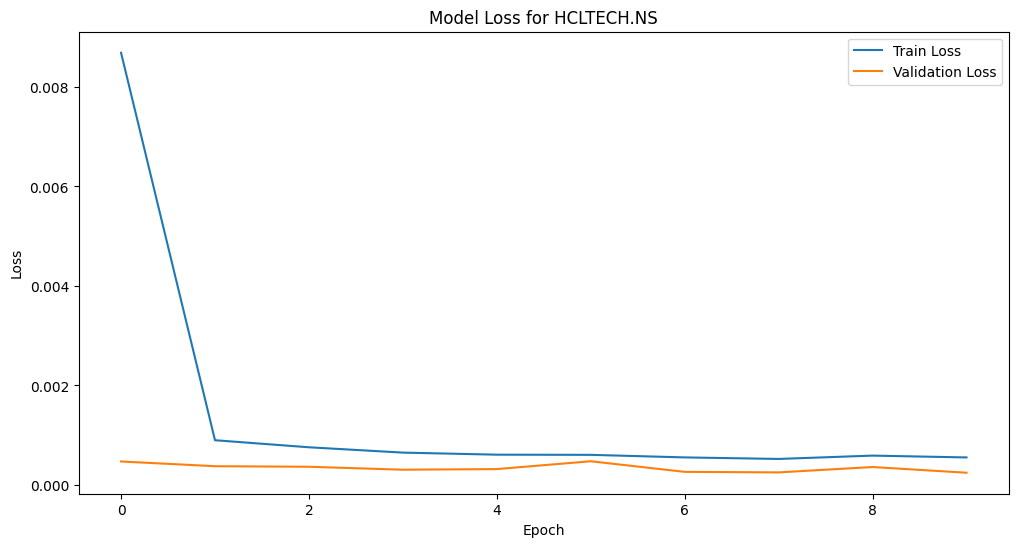

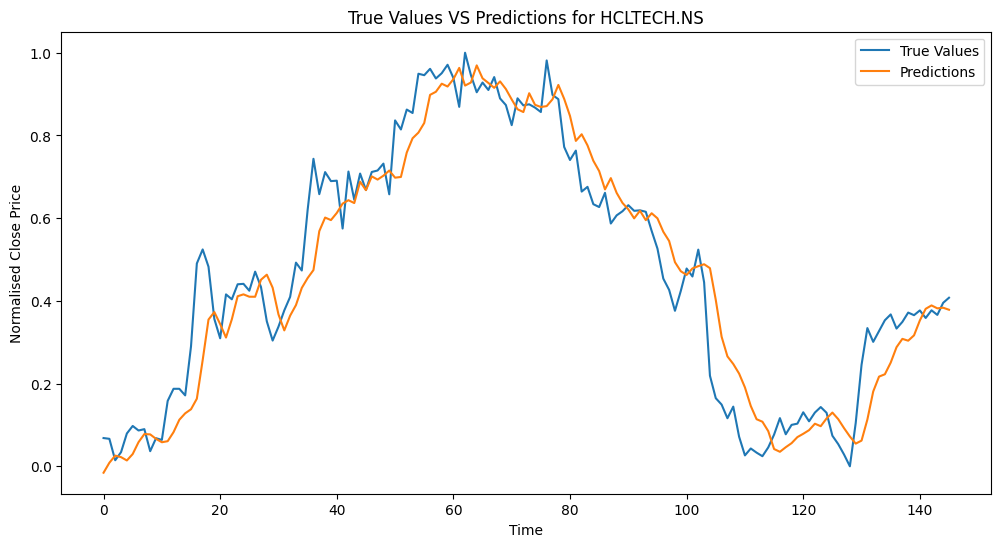

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


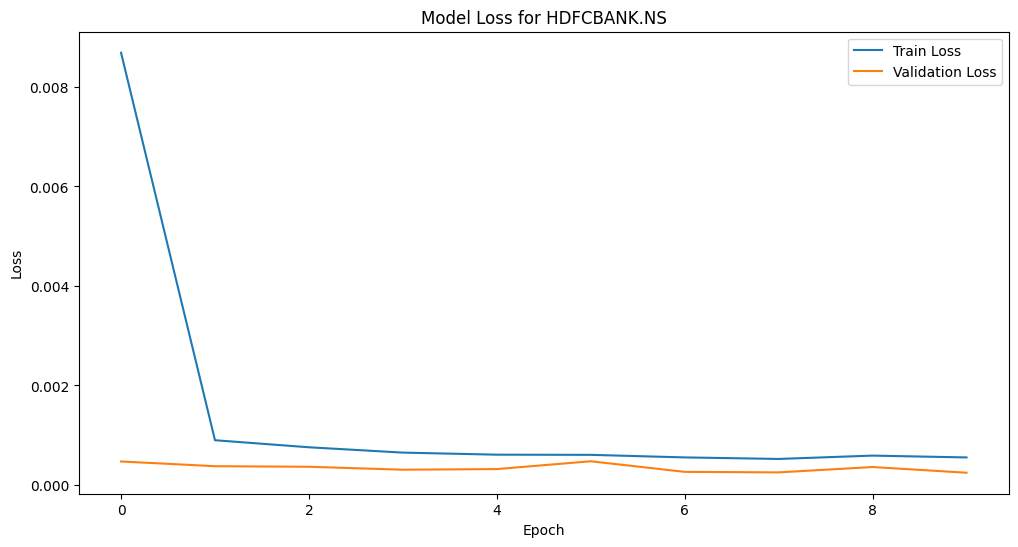

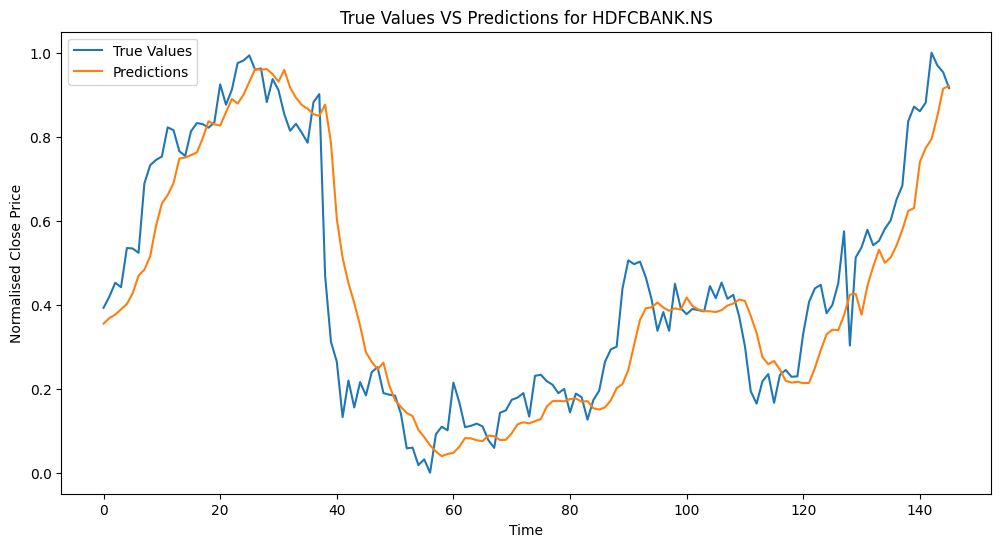

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


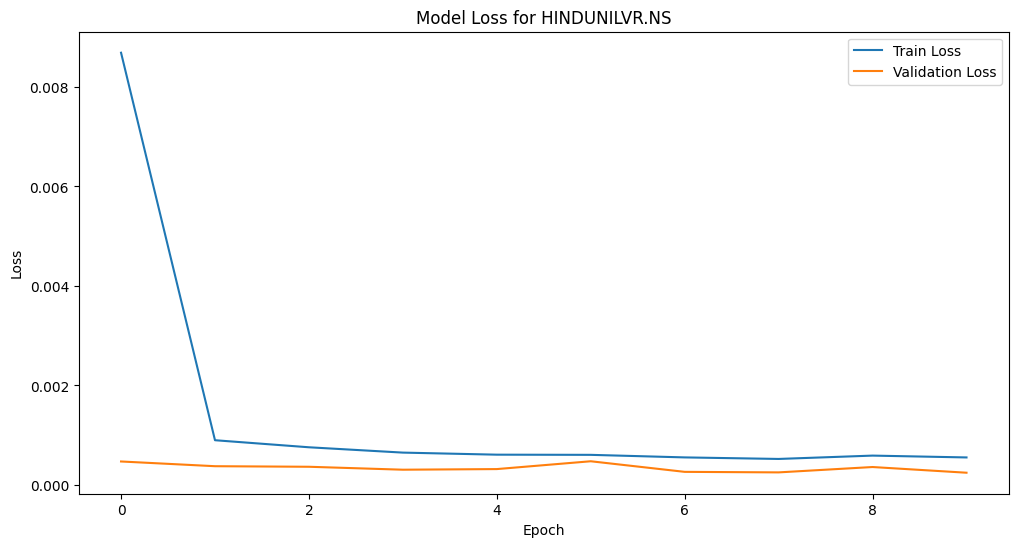

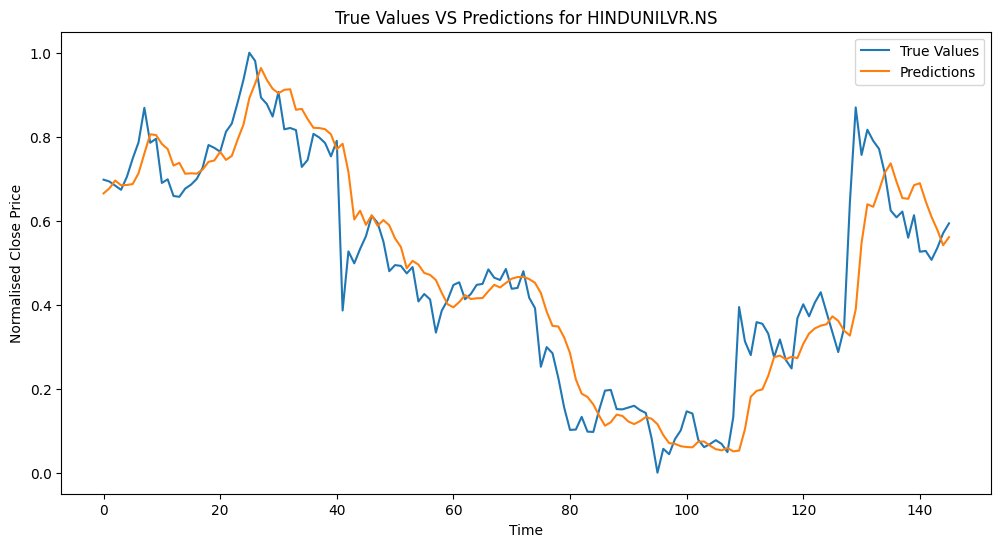

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


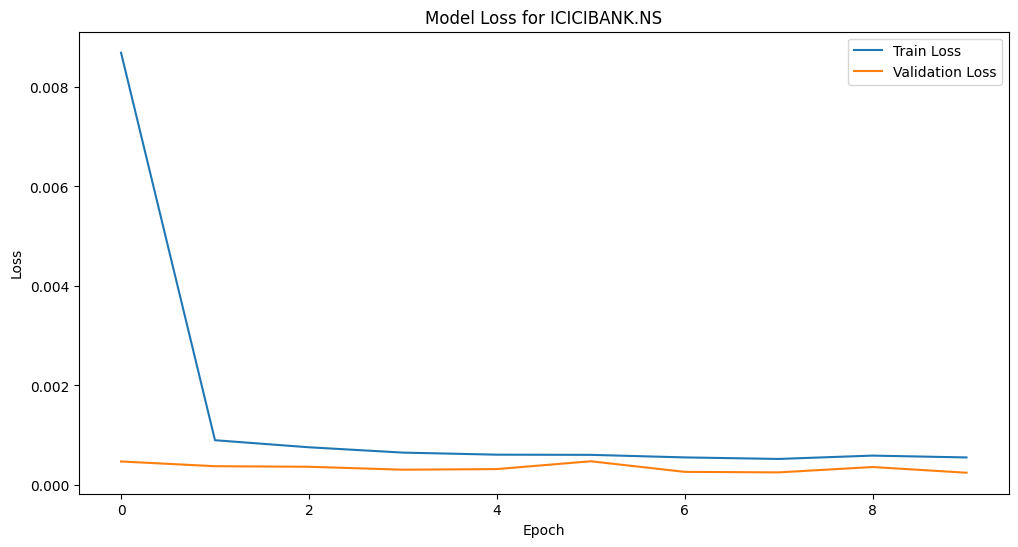

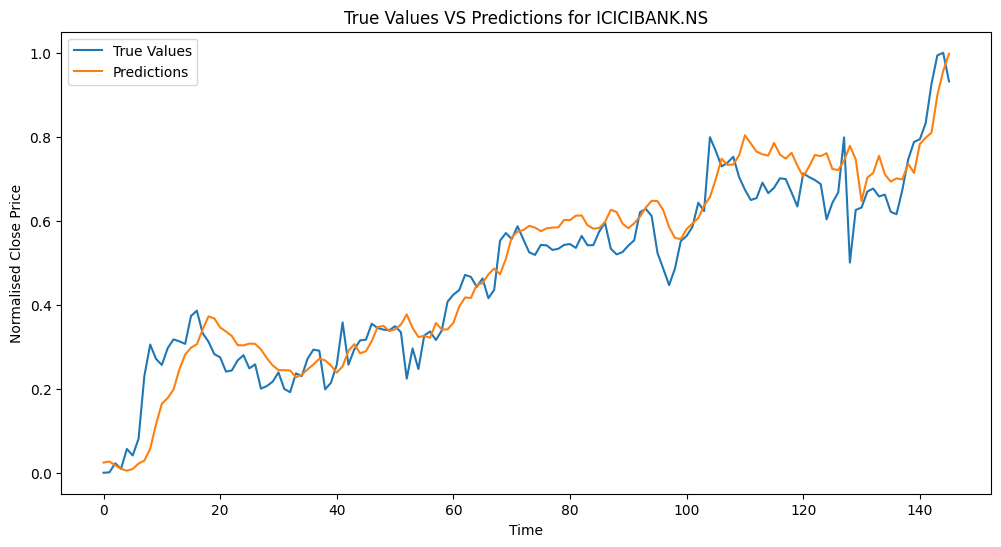

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


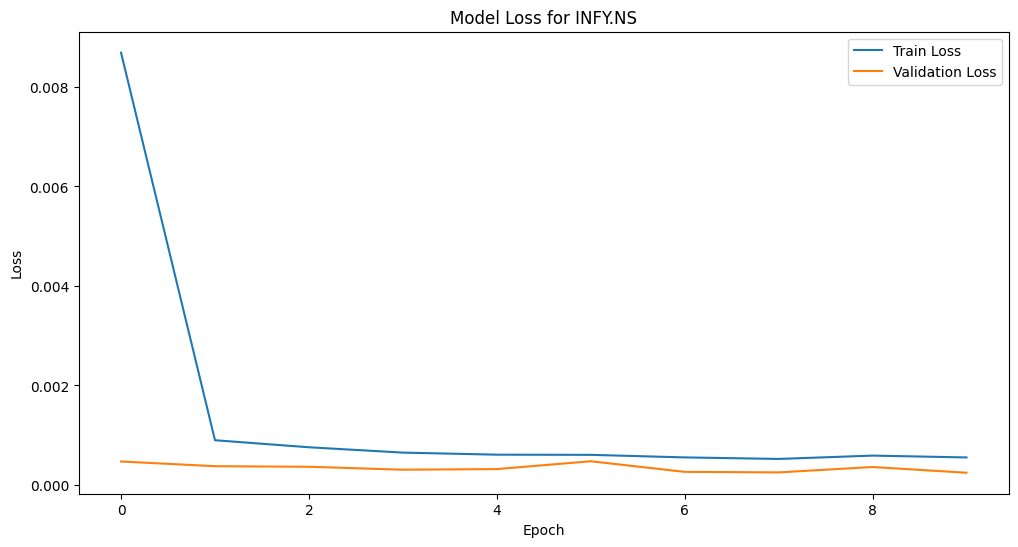

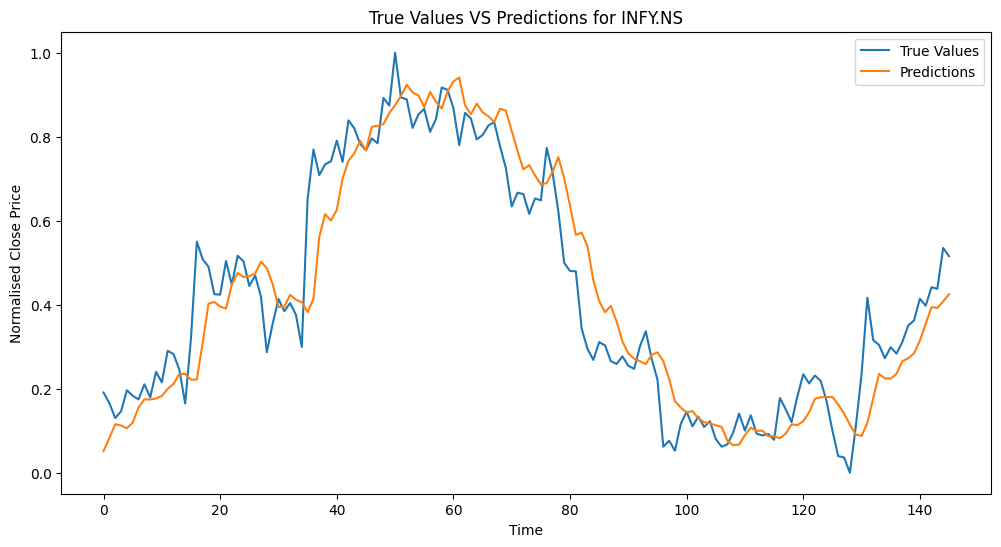

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


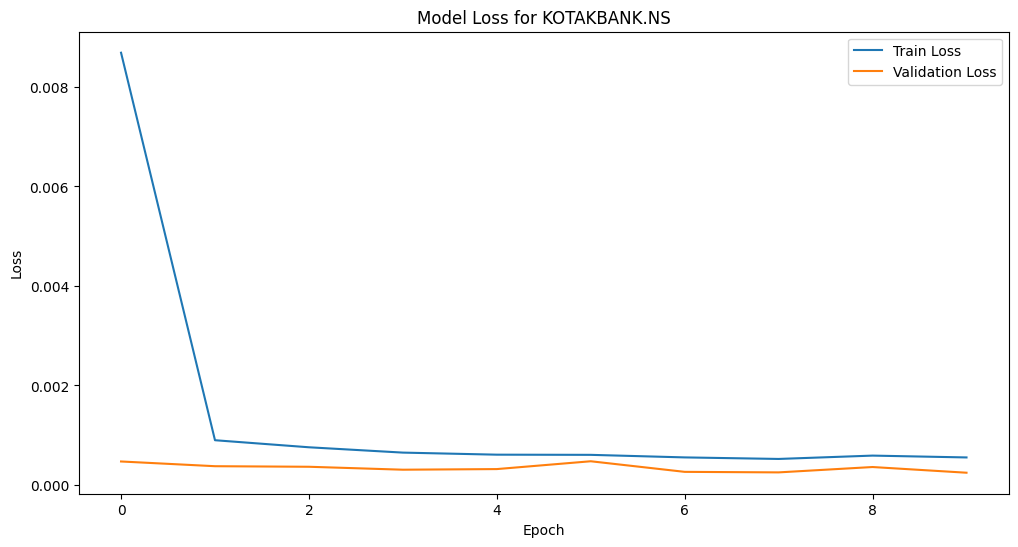

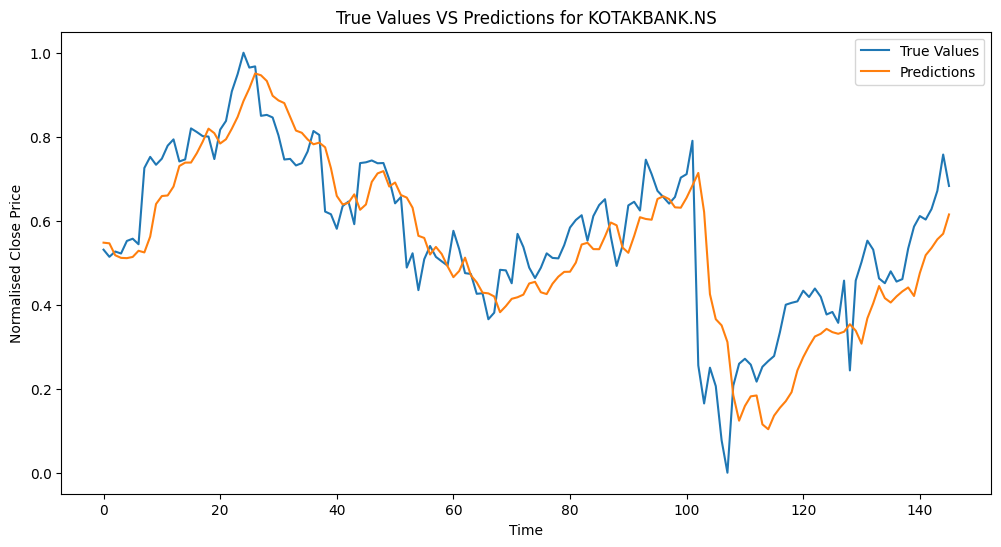

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


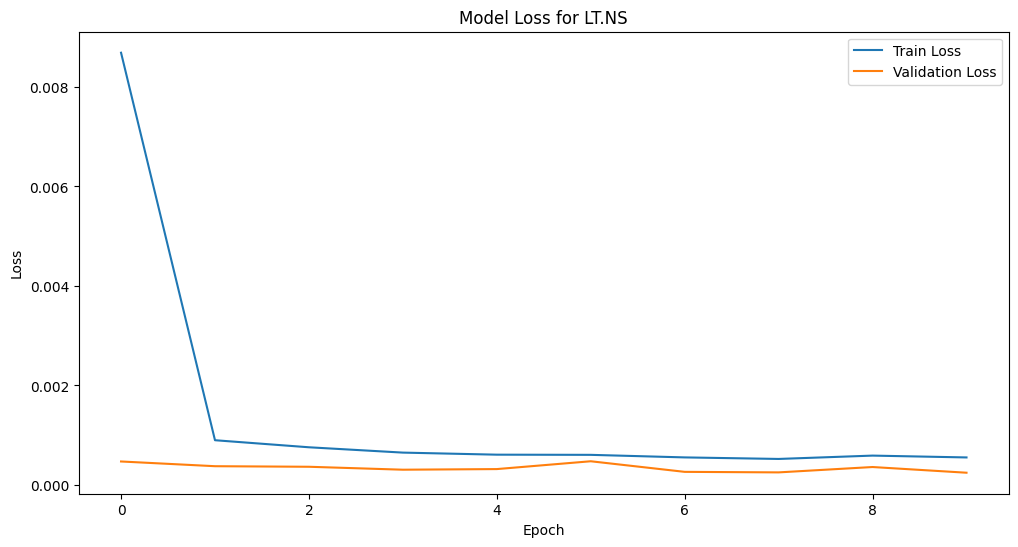

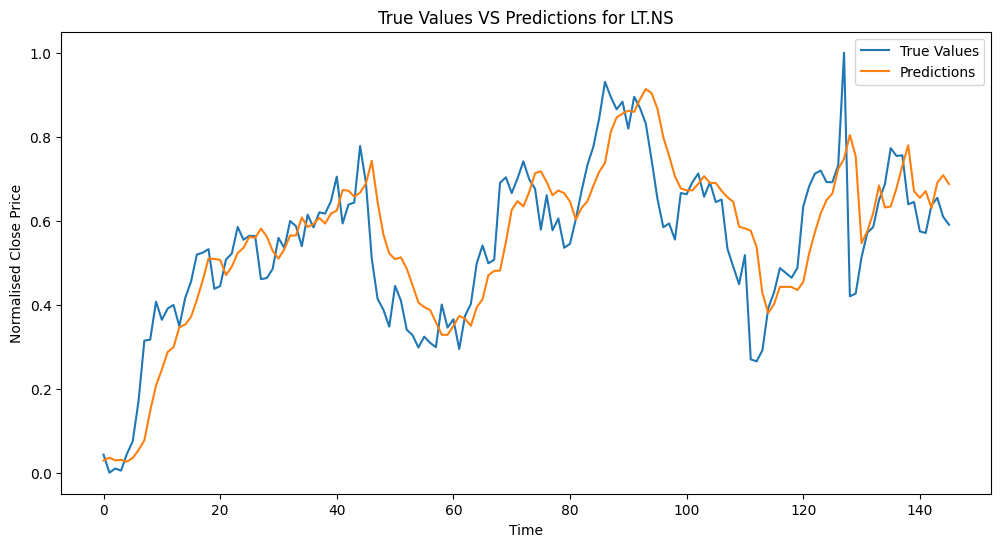

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


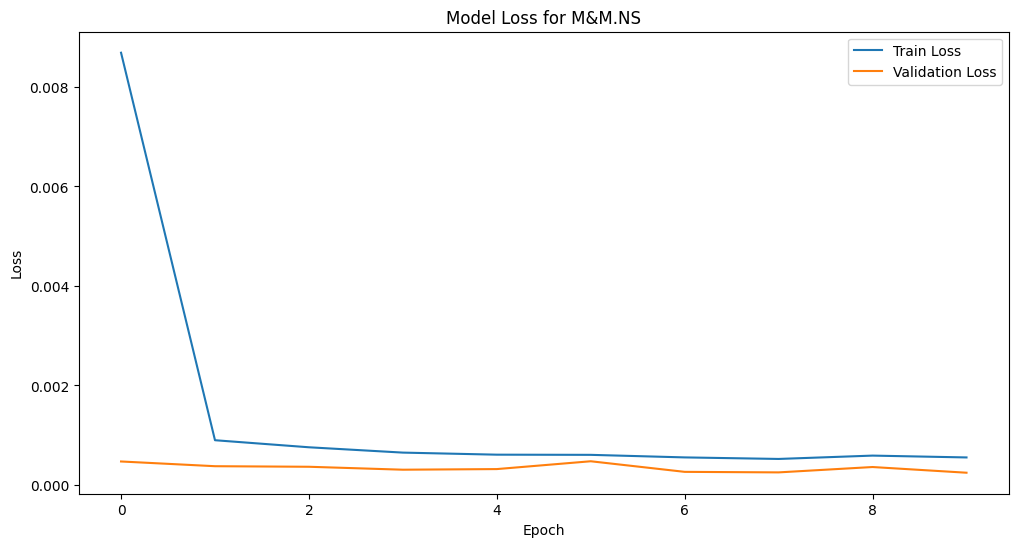

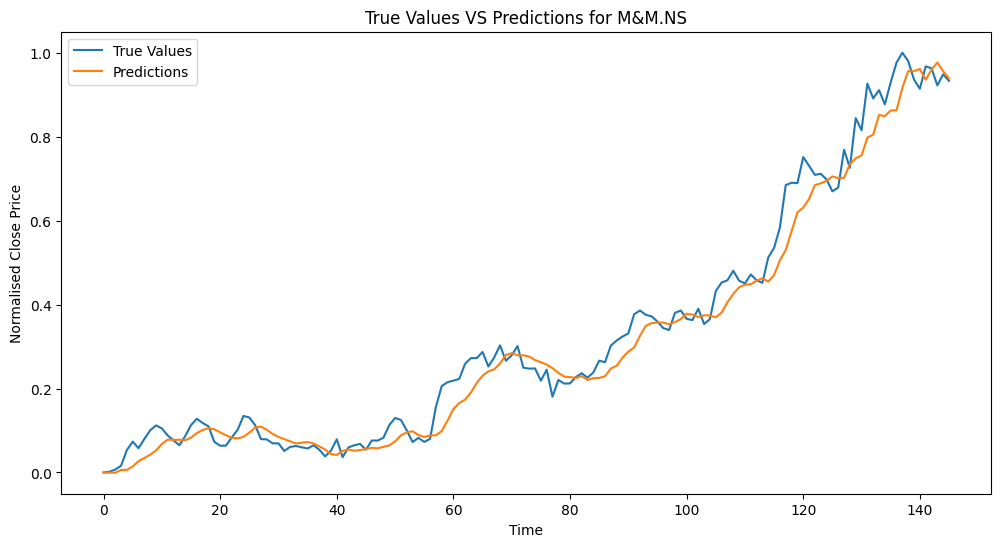

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


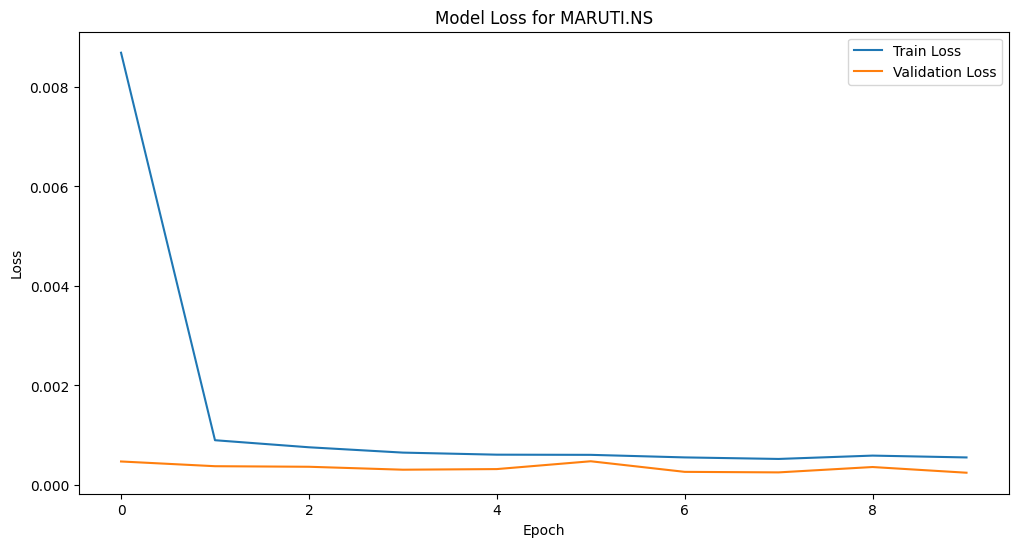

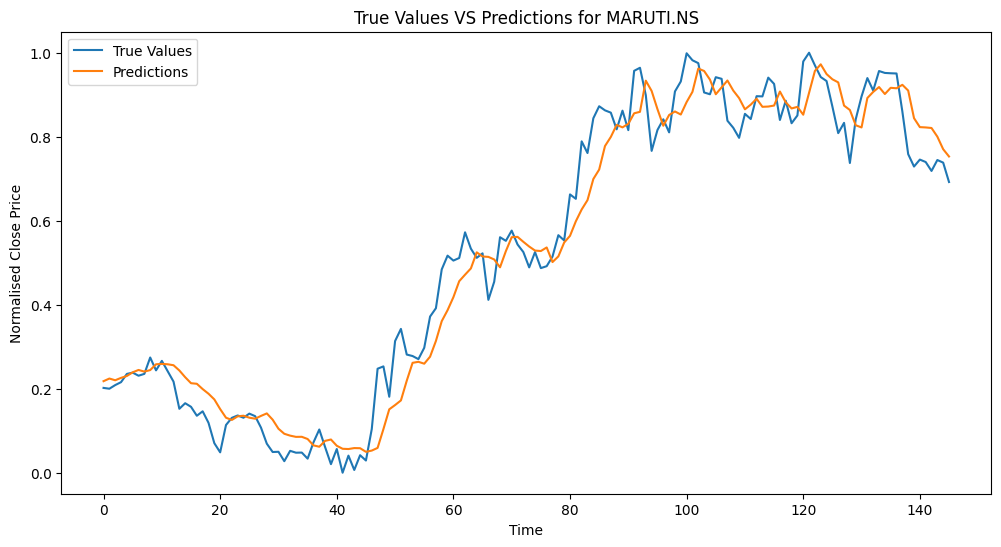

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


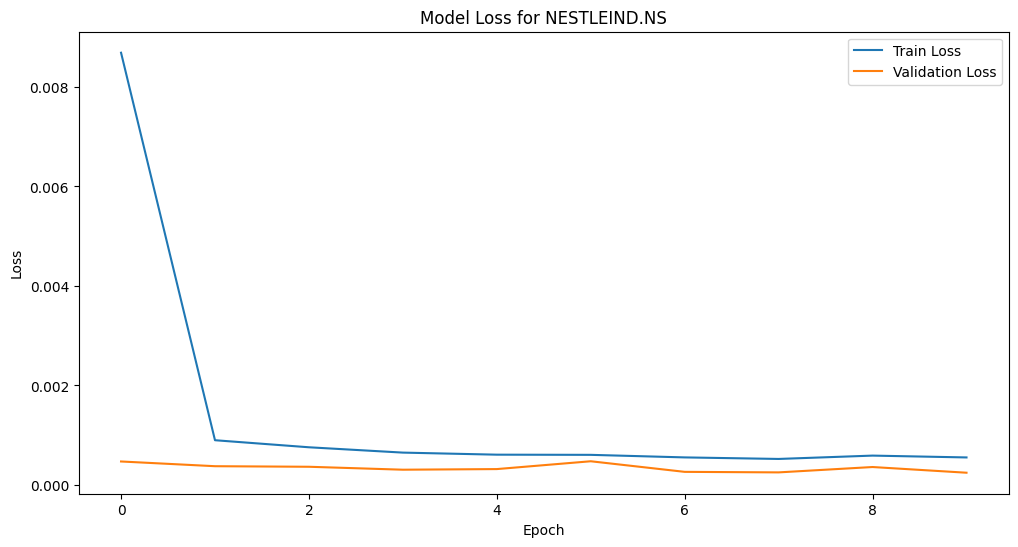

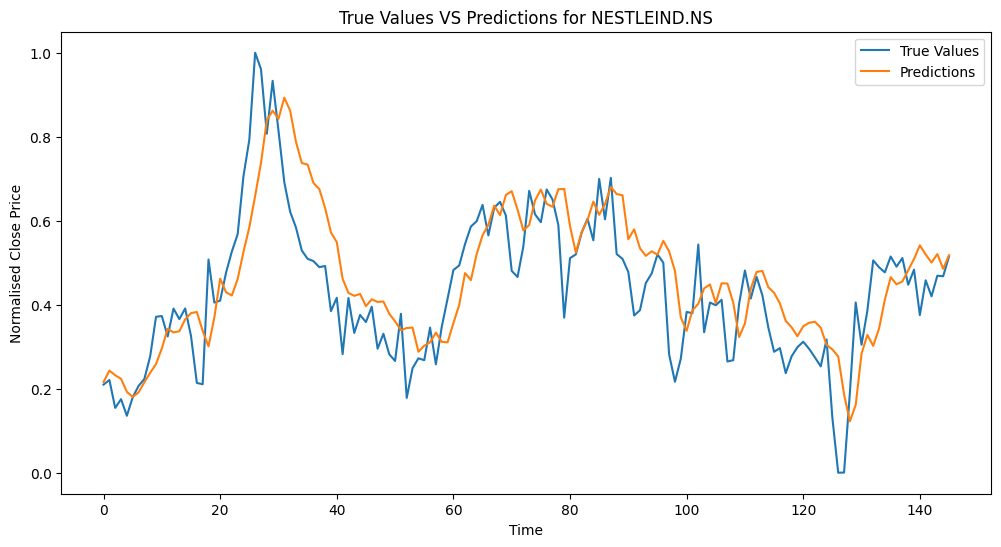

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


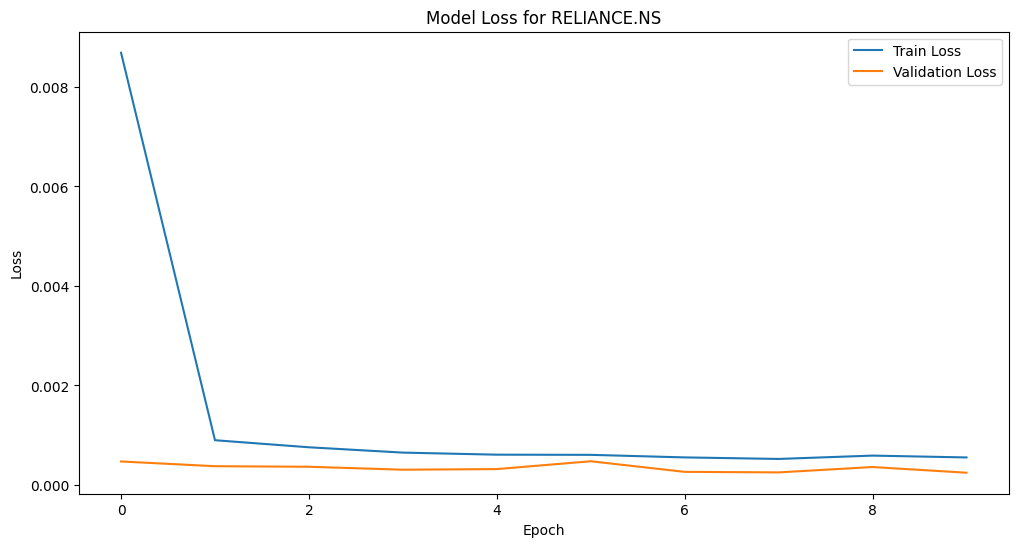

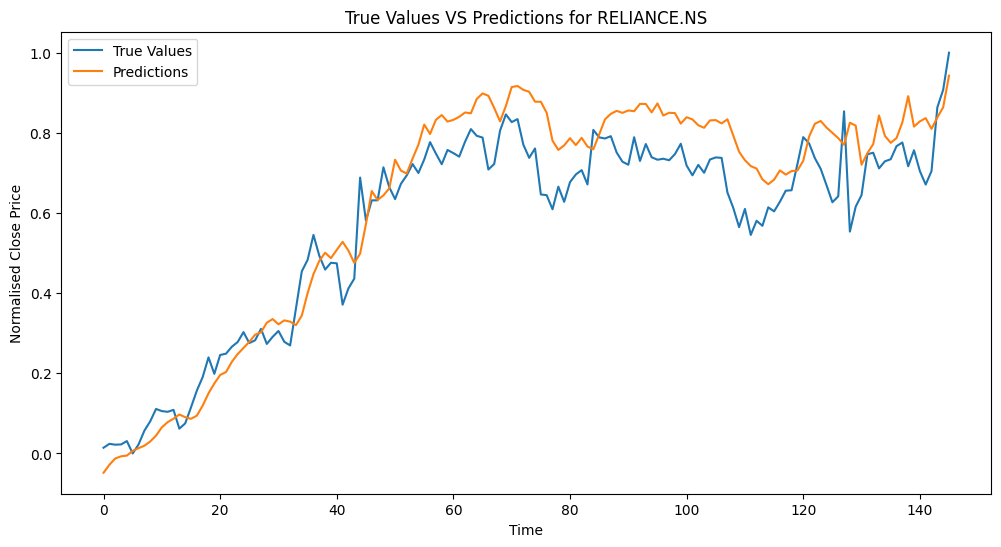

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


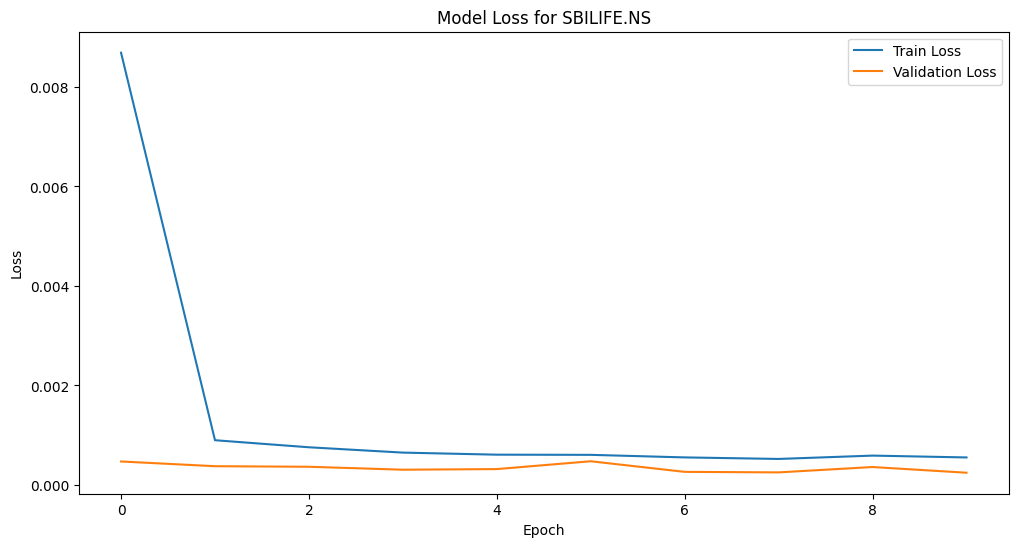

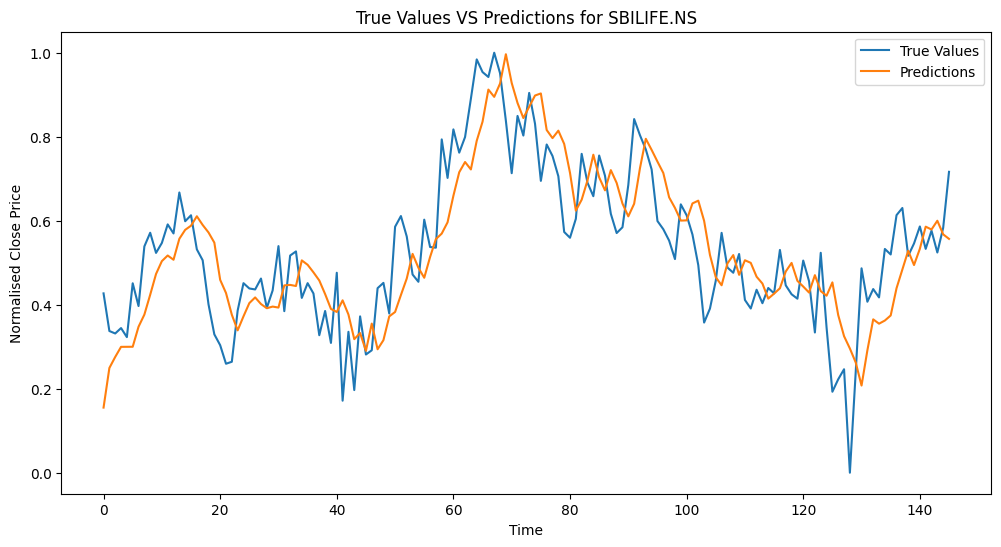

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


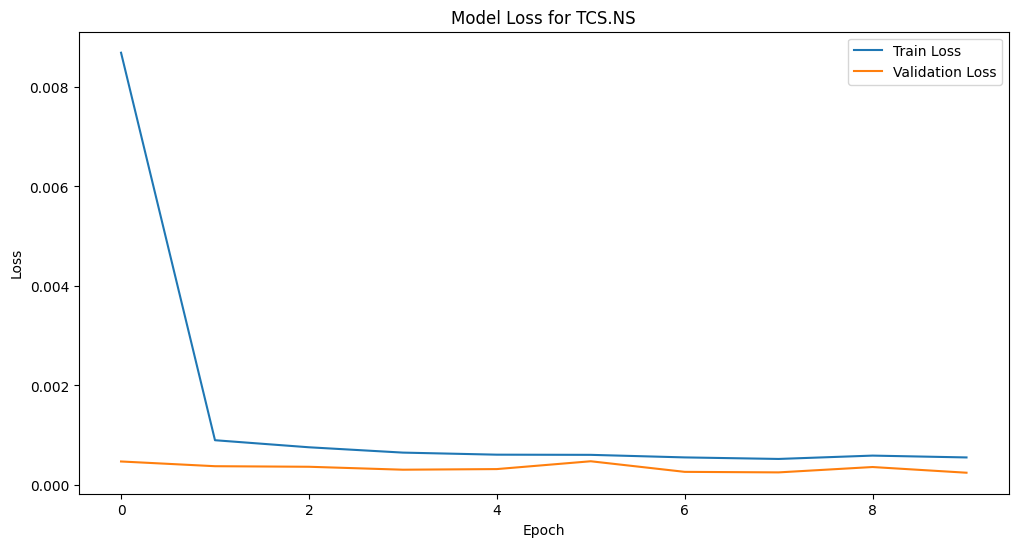

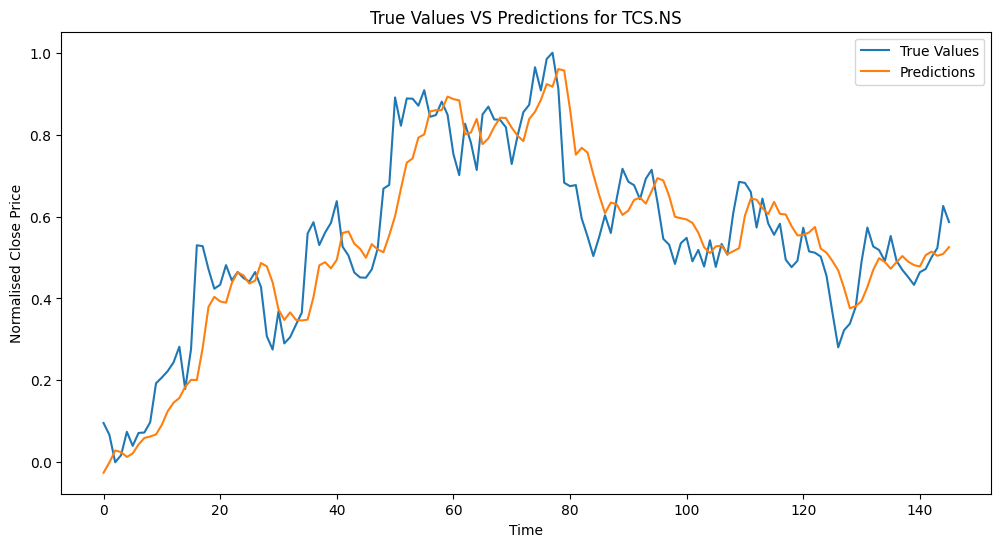

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


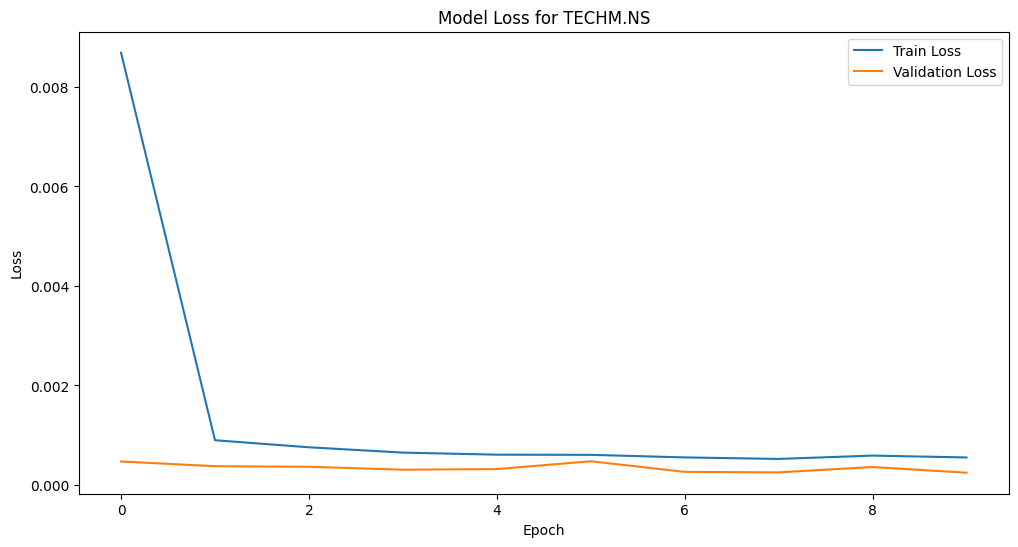

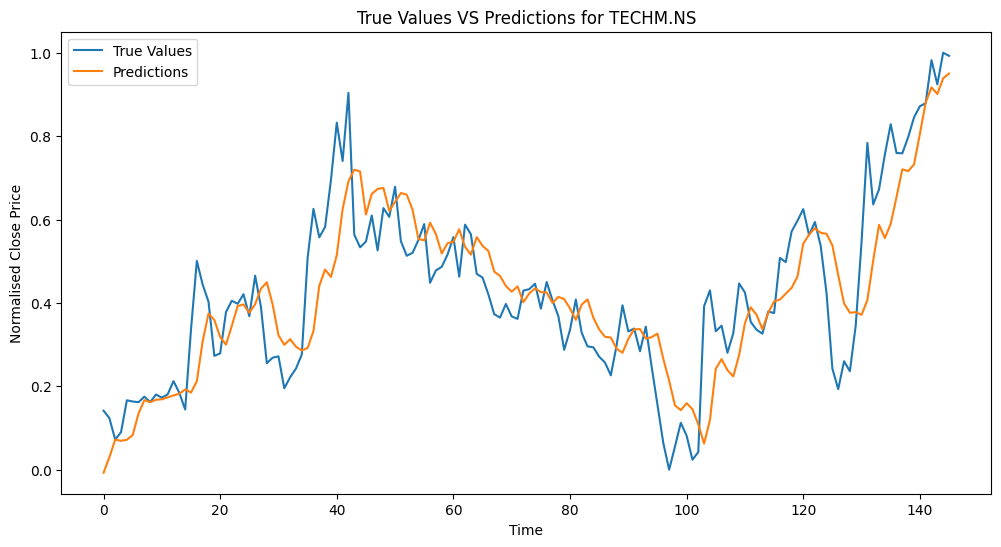

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


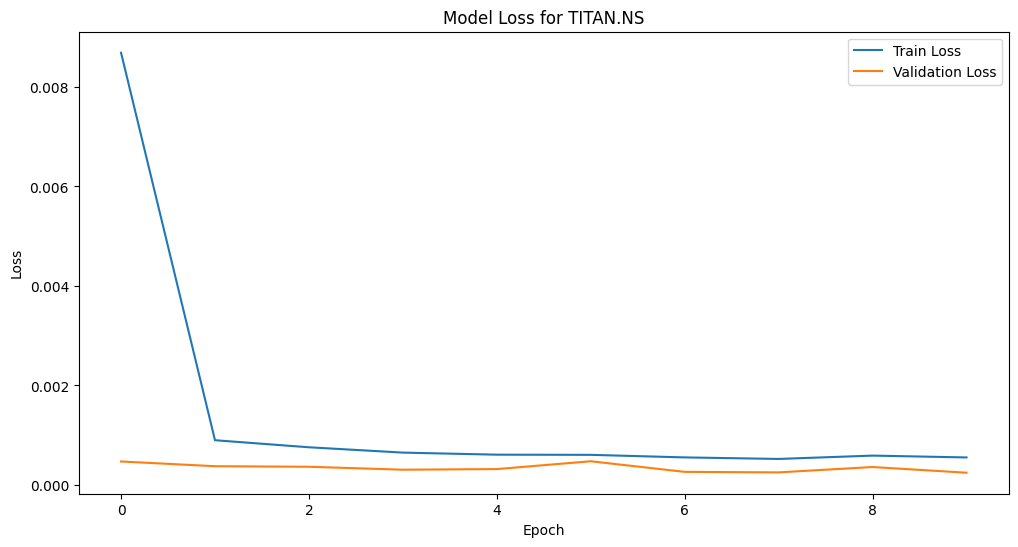

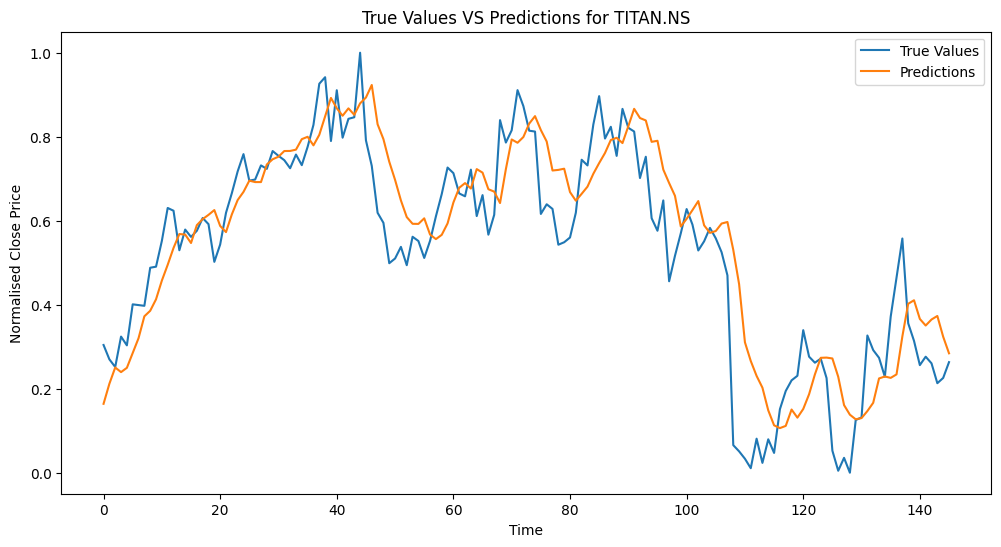

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


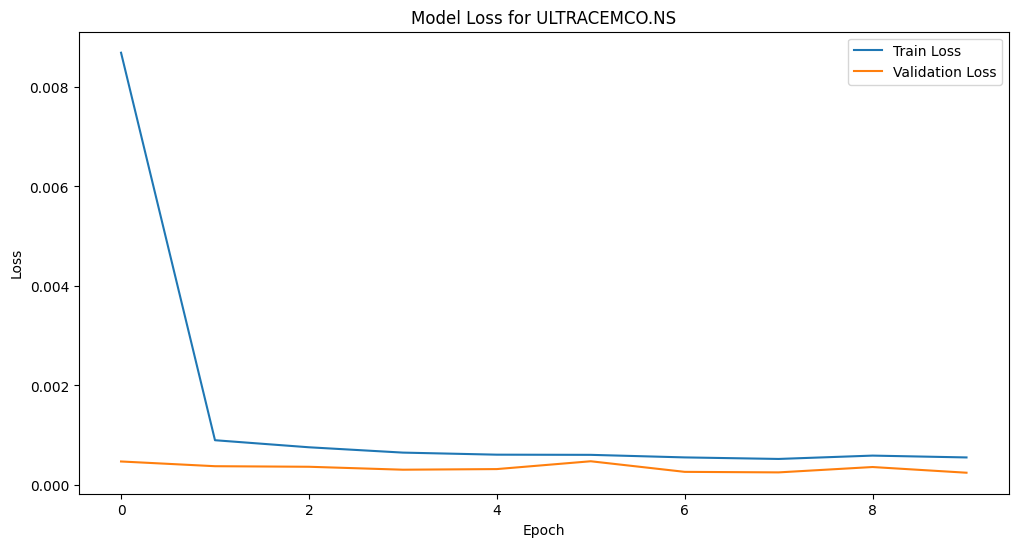

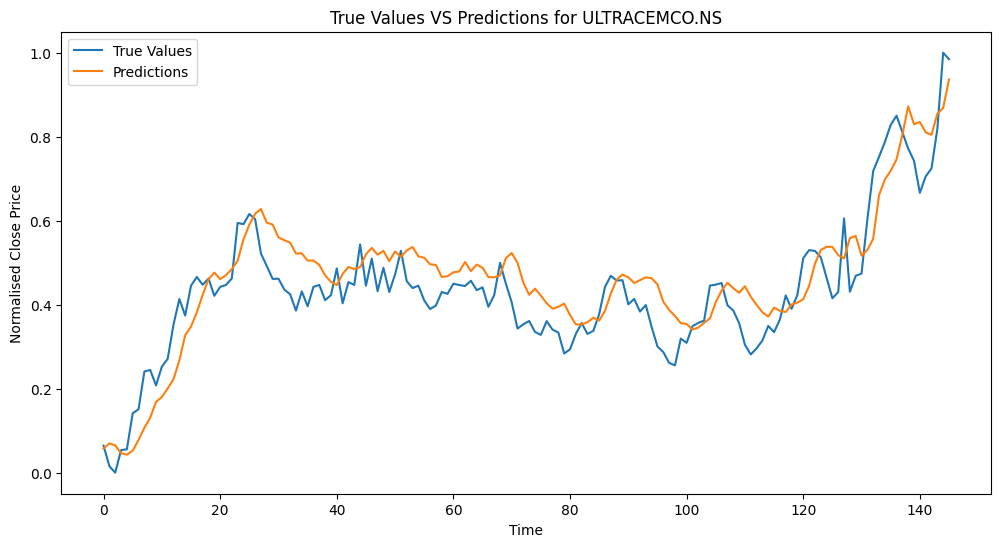

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


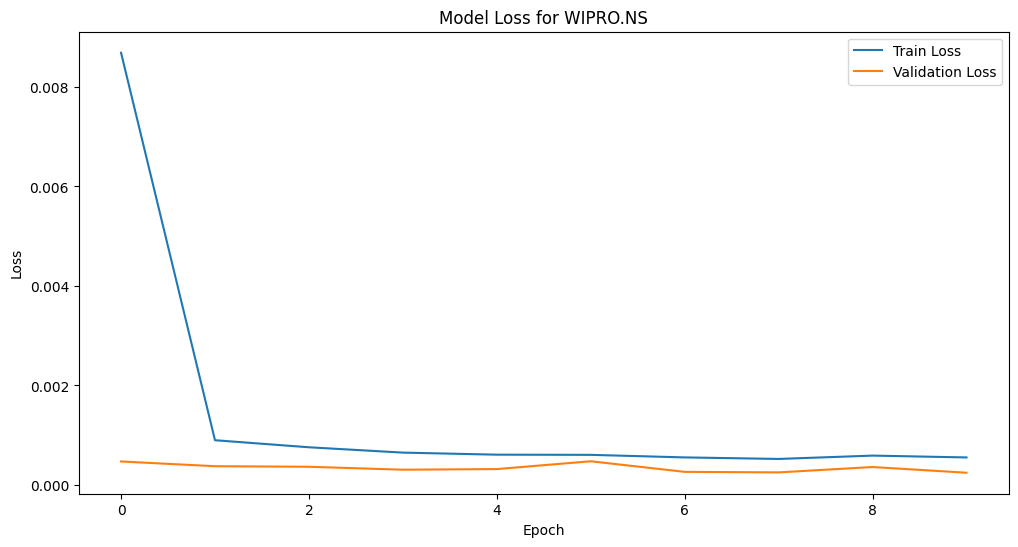

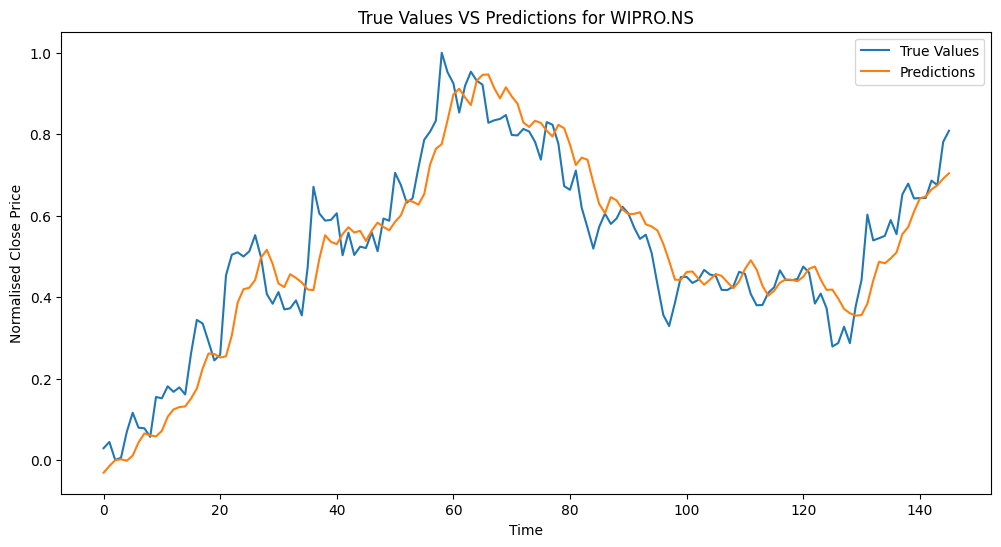

           Ticker       MSE      RMSE       MAE
0   ASIANPAINT.NS  0.068825  0.084618  0.008054
1   BAJFINANCE.NS  0.098451  0.125623  0.008054
2     DIVISLAB.NS  0.064611  0.082979  0.008054
3      HCLTECH.NS  0.068805  0.090984  0.008054
4     HDFCBANK.NS  0.085731  0.118063  0.008054
5   HINDUNILVR.NS  0.069233  0.099832  0.008054
6    ICICIBANK.NS  0.056684  0.073437  0.008054
7         INFY.NS  0.074437  0.100269  0.008054
8    KOTAKBANK.NS  0.084990  0.112456  0.008054
9           LT.NS  0.081503  0.108961  0.008054
10         M&M.NS  0.034547  0.045889  0.008054
11      MARUTI.NS  0.054054  0.068754  0.008054
12   NESTLEIND.NS  0.090806  0.116088  0.008054
13    RELIANCE.NS  0.079534  0.096577  0.008054
14     SBILIFE.NS  0.091651  0.113030  0.008054
15         TCS.NS  0.073935  0.097380  0.008054
16       TECHM.NS  0.088833  0.117780  0.008054
17       TITAN.NS  0.091058  0.119217  0.008054
18  ULTRACEMCO.NS  0.067304  0.078407  0.008054
19       WIPRO.NS  0.061965  0.081066  0

In [44]:
# plot results for each stock

def plot_results_for_each_stock(data, model, sequence_length=60):
  tickers = stock_data['ticker'].unique()
  gru_results = [] # store result for each stock

  for ticker in tickers:
    ticker_data = stock_data[stock_data['ticker'] == ticker] # fit the data
    if ticker_data.shape[0] <= sequence_length:
      print(f"Not Enough Data for {ticker}. Skipping...")
      continue


    # prepare data for current selected company

    X, y, scaler = prepare_data(ticker_data, sequence_length)


    # prediction for each stock

    gru_predictions = gru_model.predict(X)


    # Normalise the prediction values
    gru_scaler_y = MinMaxScaler(feature_range=(0, 1))
    y = np.concatenate([y, y[-len(gru_predictions):]]) # append to match the prediction length
    gru_y_scaled = gru_scaler_y.fit_transform(y.reshape(-1, 1)) # reshape
    gru_predictions_scaled = gru_scaler_y.transform(gru_predictions)


    # calculate performance metrics

    gru_mse = mean_squared_error(gru_y_scaled[-len(gru_predictions):],
                                    gru_predictions_scaled)
    gru_rmse = np.sqrt(gru_mse)
    gru_mse = mean_absolute_error(gru_y_scaled[-len(gru_predictions):],
                                    gru_predictions_scaled)


    # store performance metrics for each stock

    gru_results.append({
        'Ticker': ticker,
        'MSE': gru_mse,
        'RMSE': gru_rmse,
        'MAE': gru_mae
    })


    # plot training & validation loss curves

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss for {ticker}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    # plot True Vs Predicted Price curve

    plt.figure(figsize=(12, 6))
    plt.plot(gru_y_scaled[-len(gru_predictions):], label='True Values')
    plt.plot(gru_predictions_scaled, label='Predictions')
    plt.title(f'True Values VS Predictions for {ticker}')
    plt.xlabel('Time')
    plt.ylabel('Normalised Close Price')
    plt.legend()
    plt.show()

  # converting results into DataFrame
  gru_results_df = pd.DataFrame(gru_results)
  print(gru_results_df)


  # calculate Average of all stocks

  gru_average_metrics = gru_results_df[['MSE', 'RMSE', 'MAE']].mean()
  print('Average GRU Metrics Across All Stocks: ')
  print(gru_average_metrics)


# plot results for each stock

plot_results_for_each_stock(stock_data, gru_model, sequence_length=60)

## RF(Random Forest classifier) Model

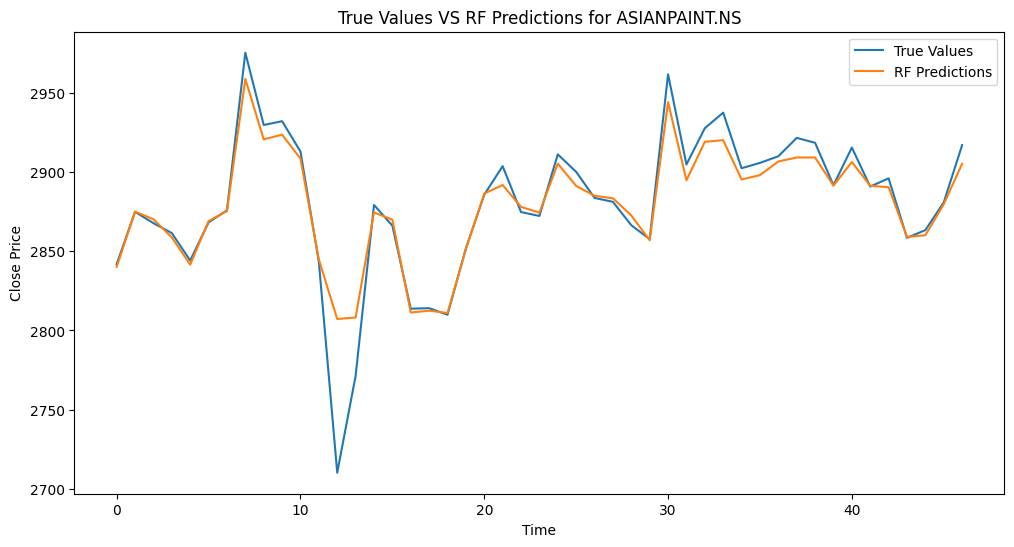

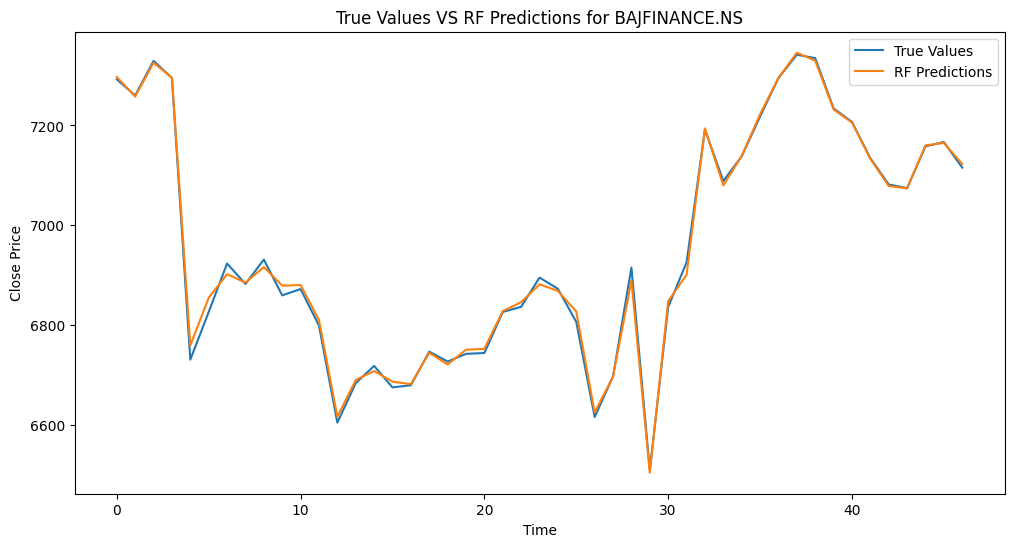

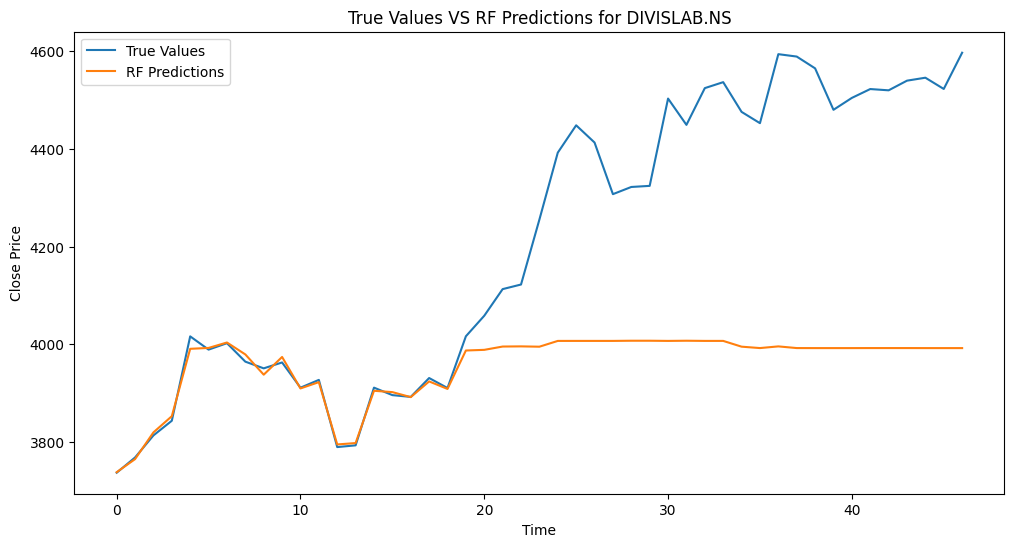

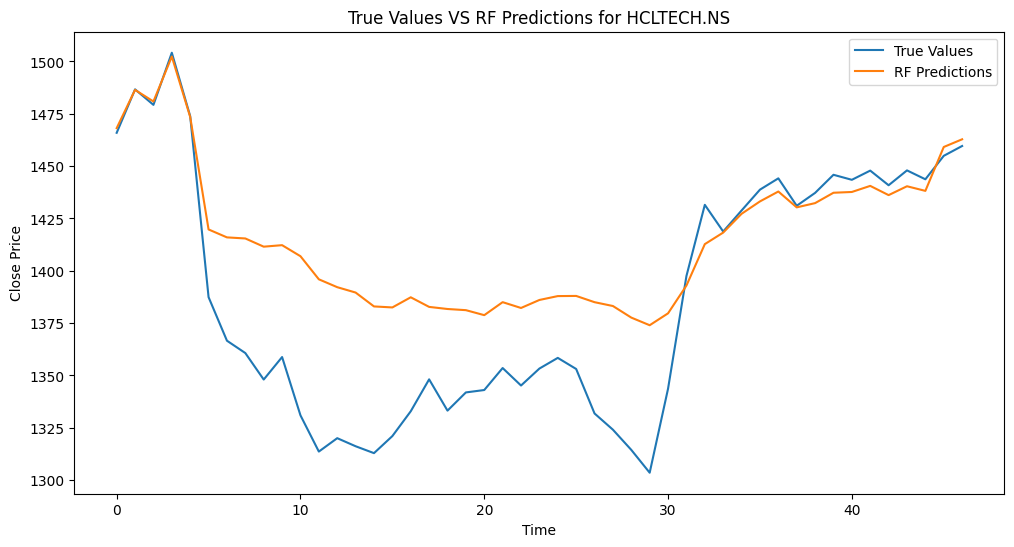

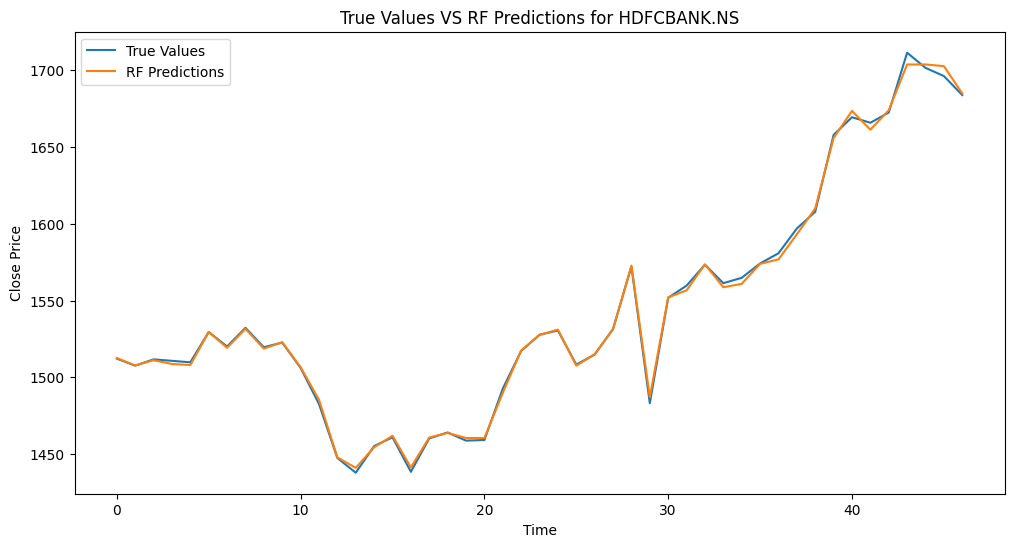

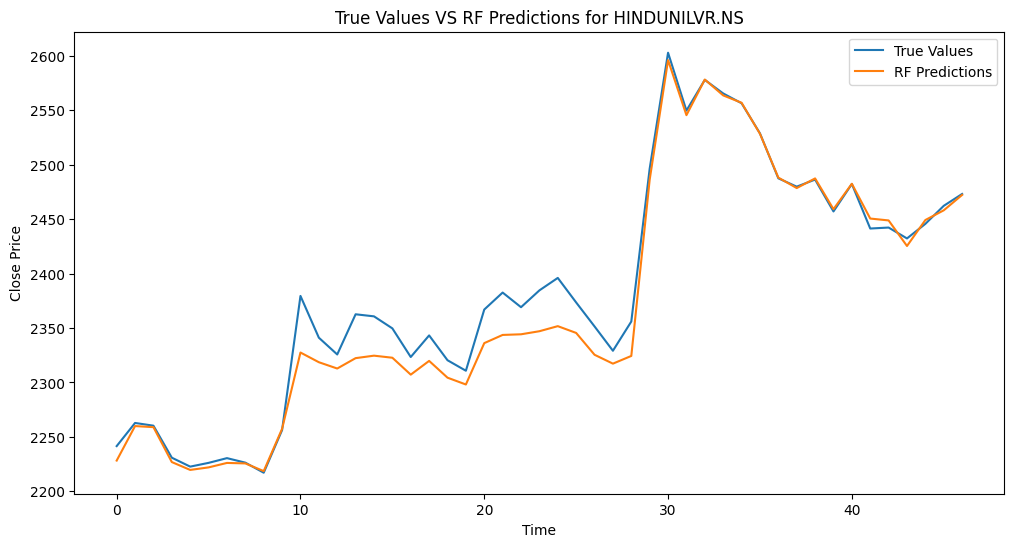

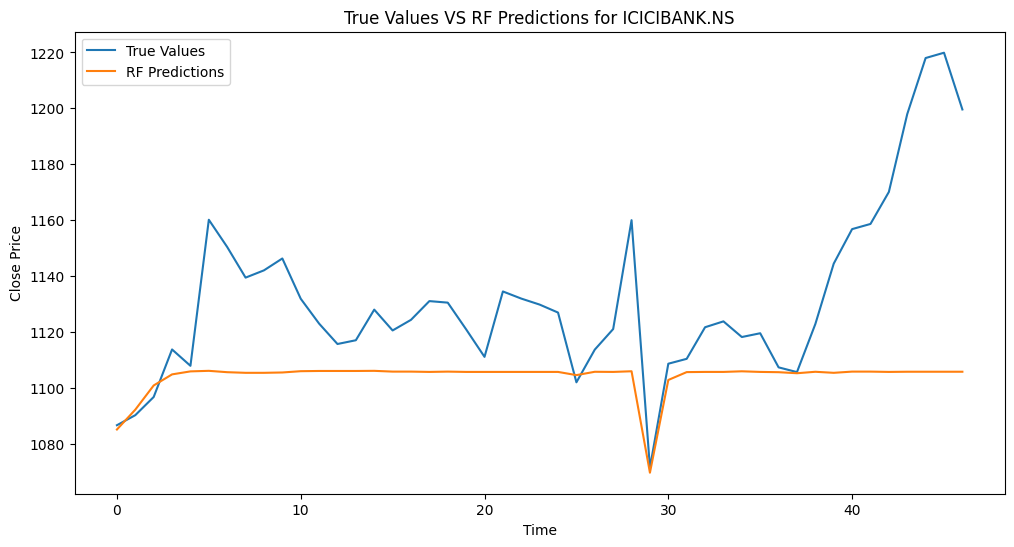

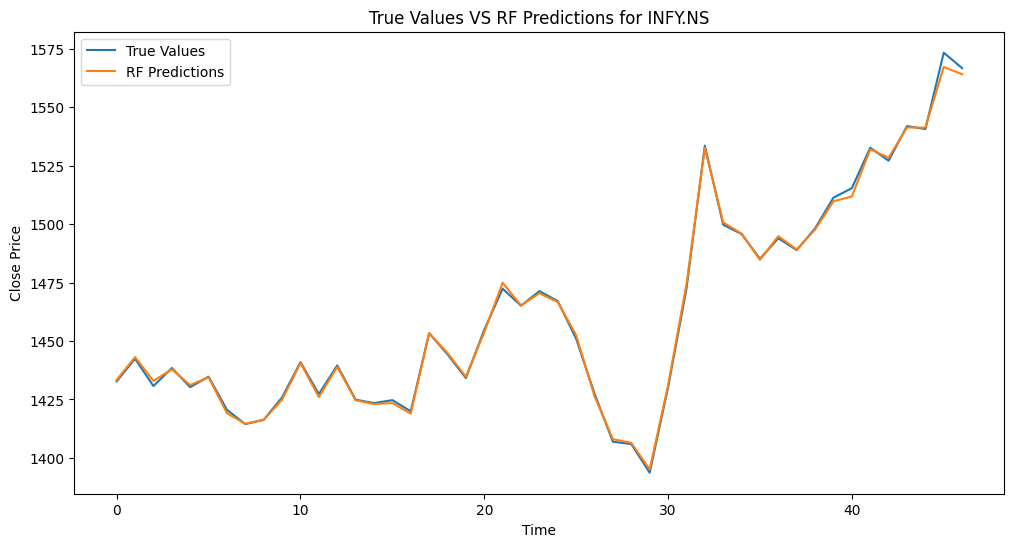

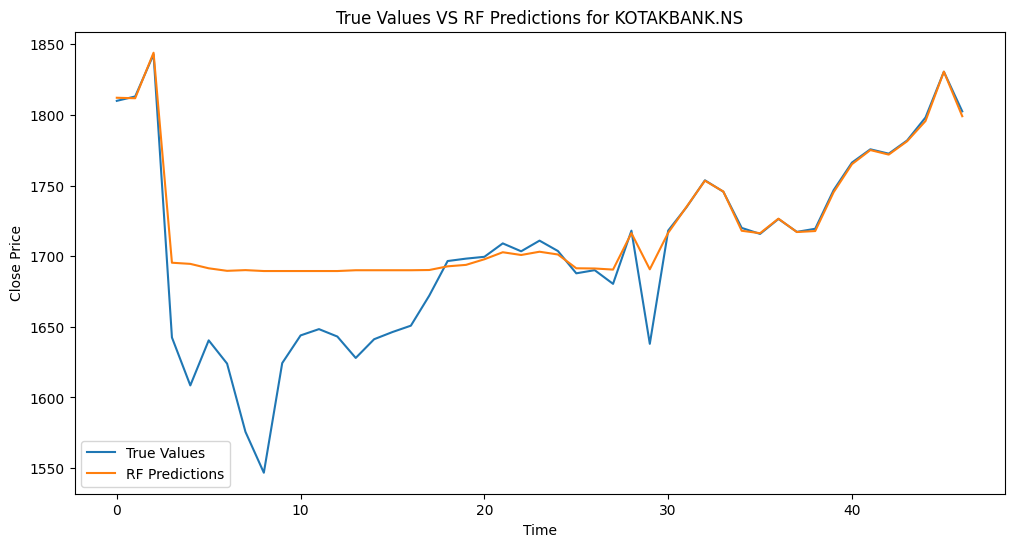

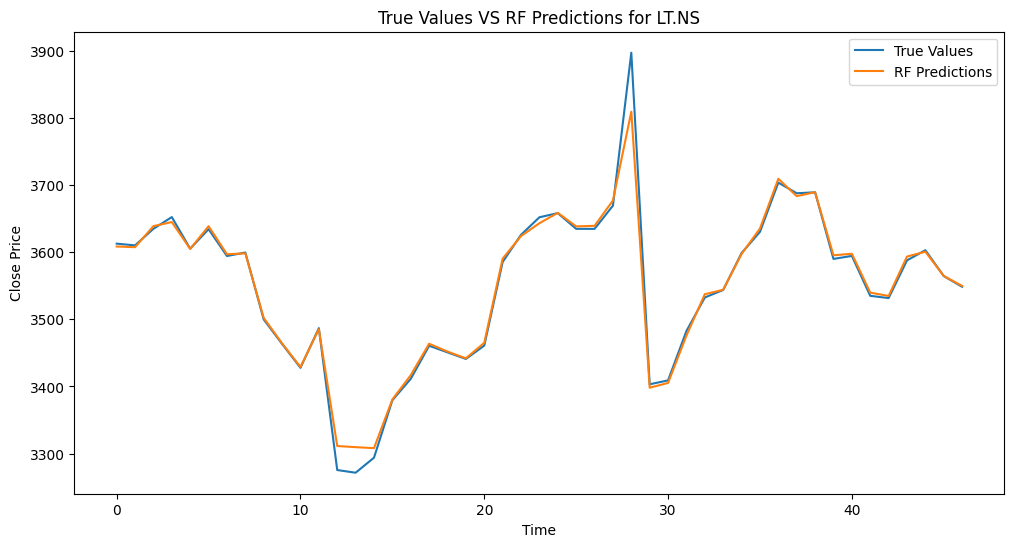

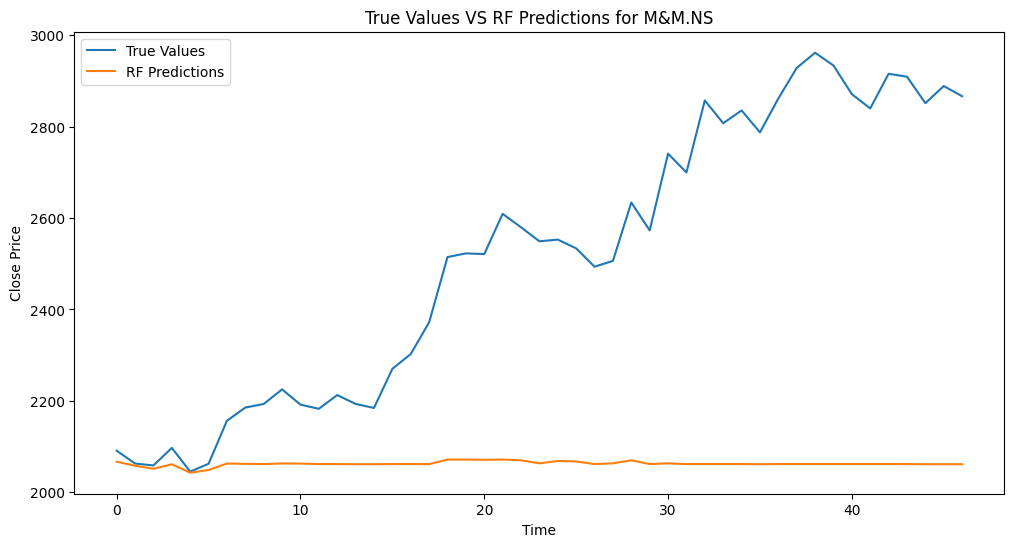

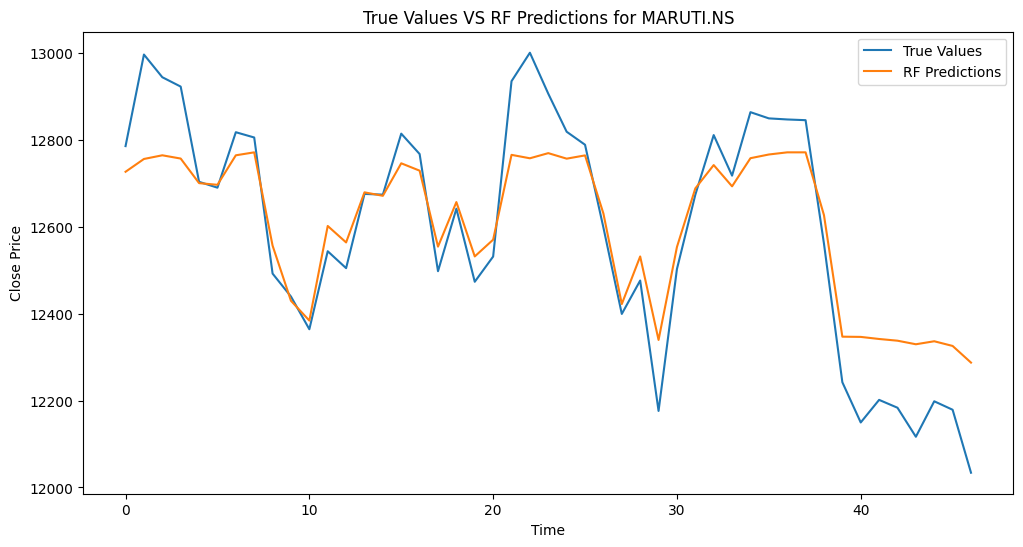

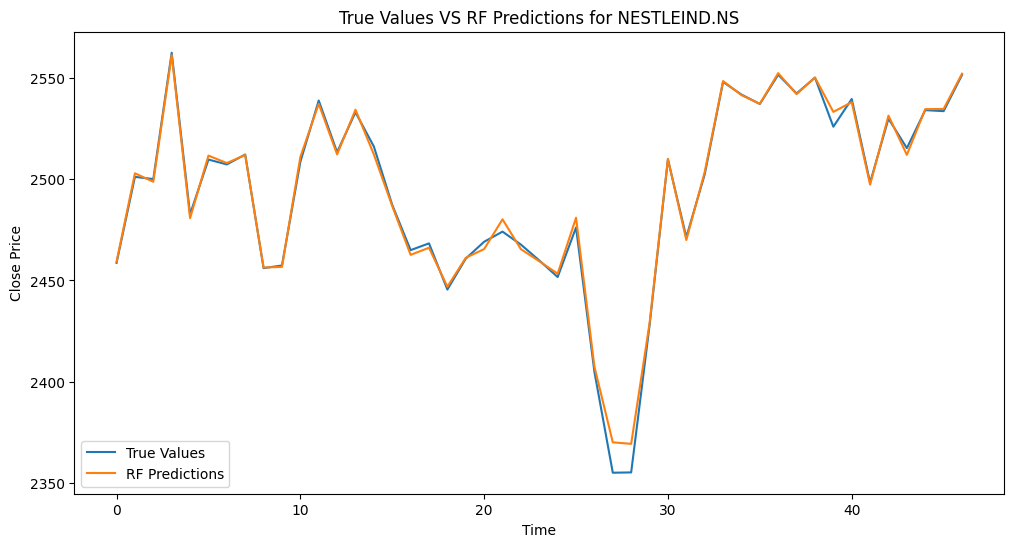

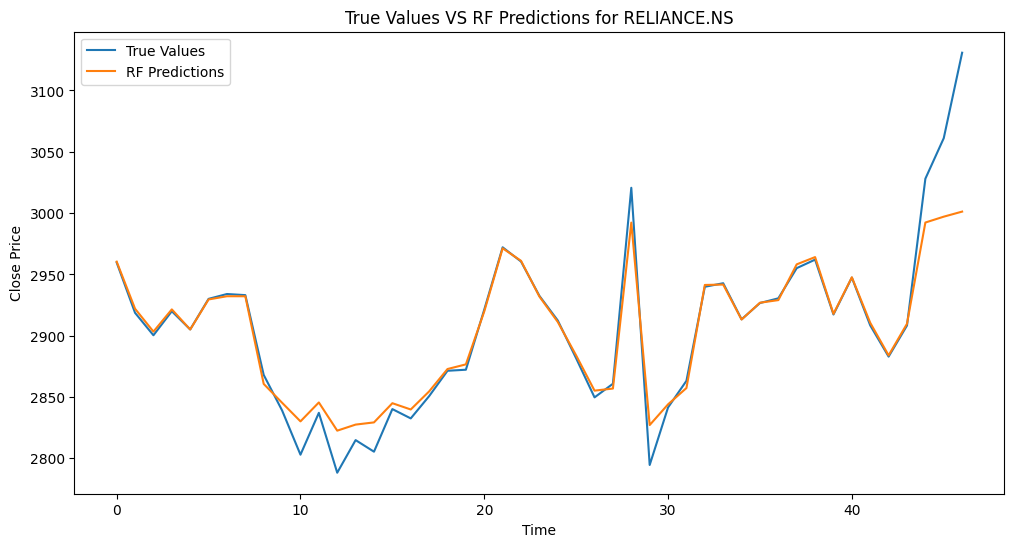

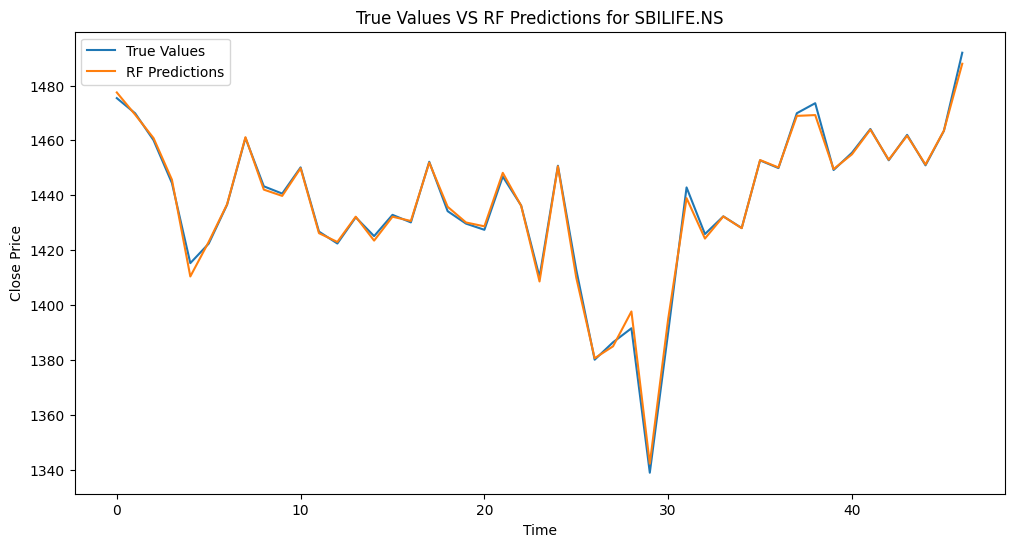

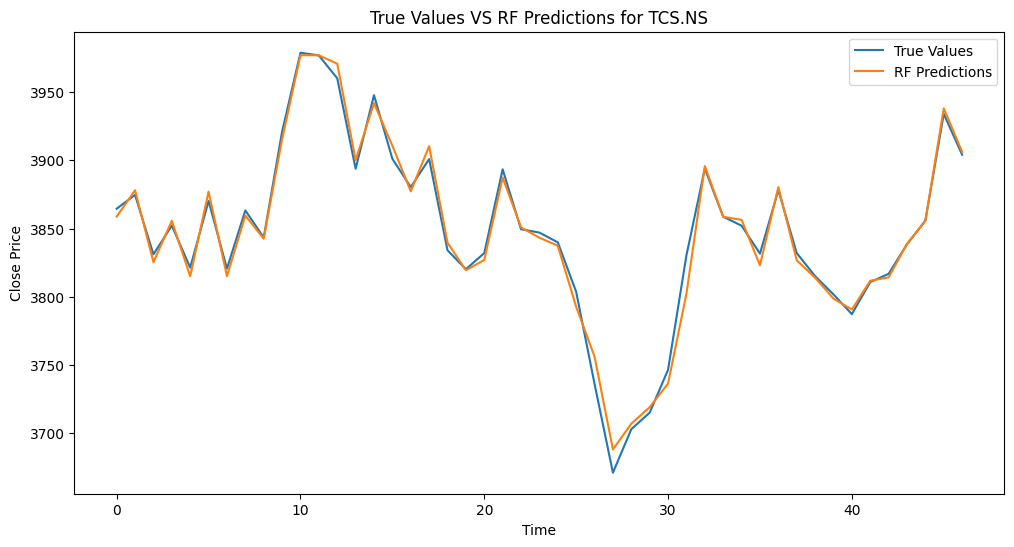

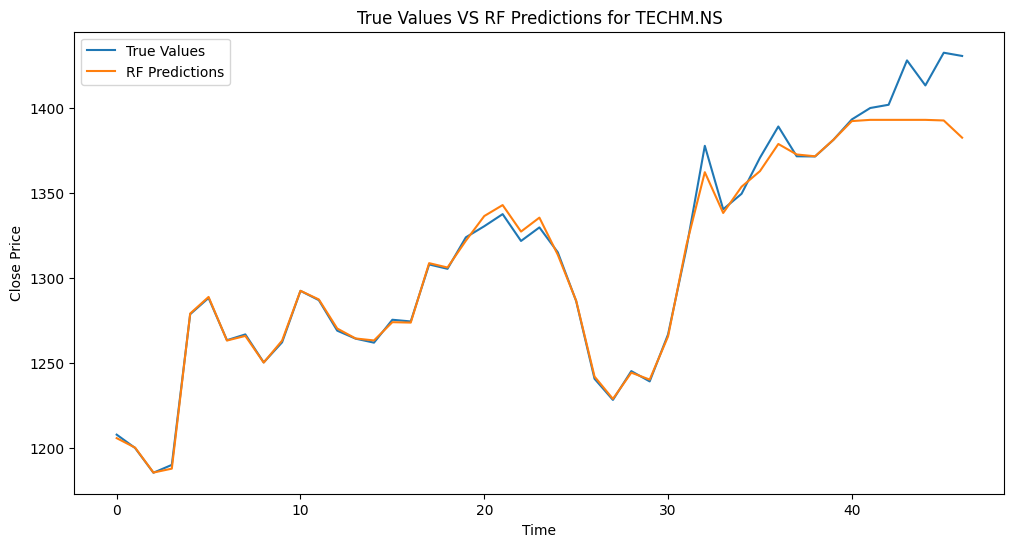

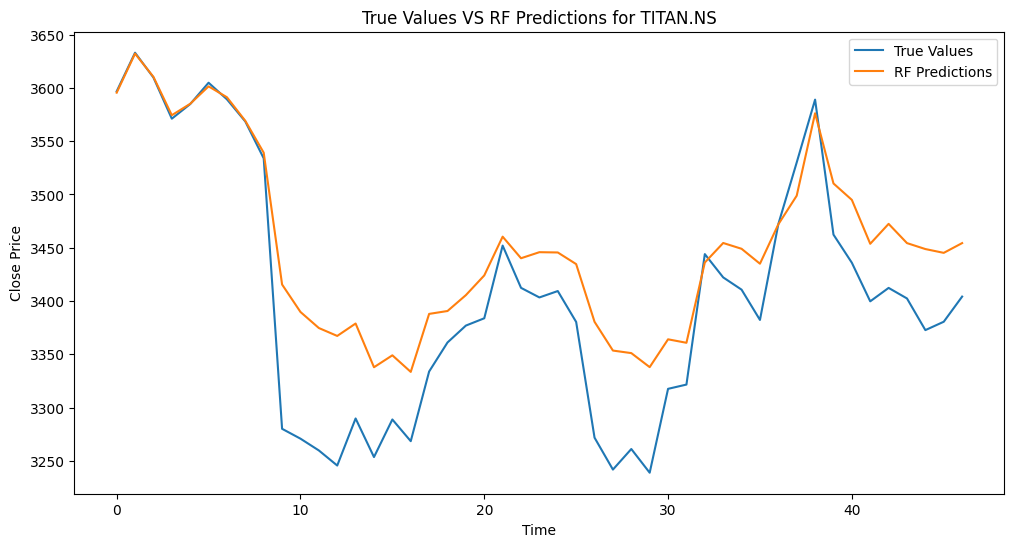

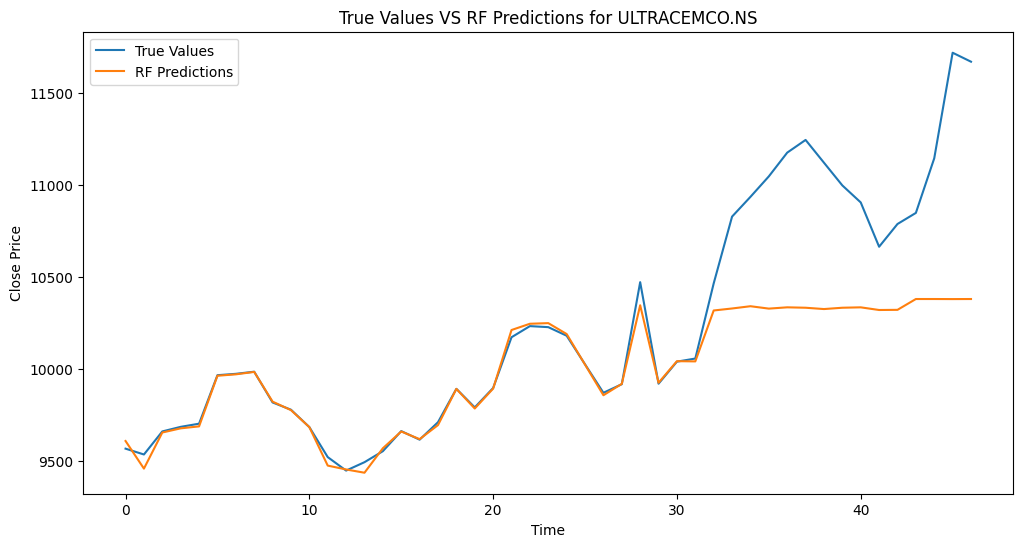

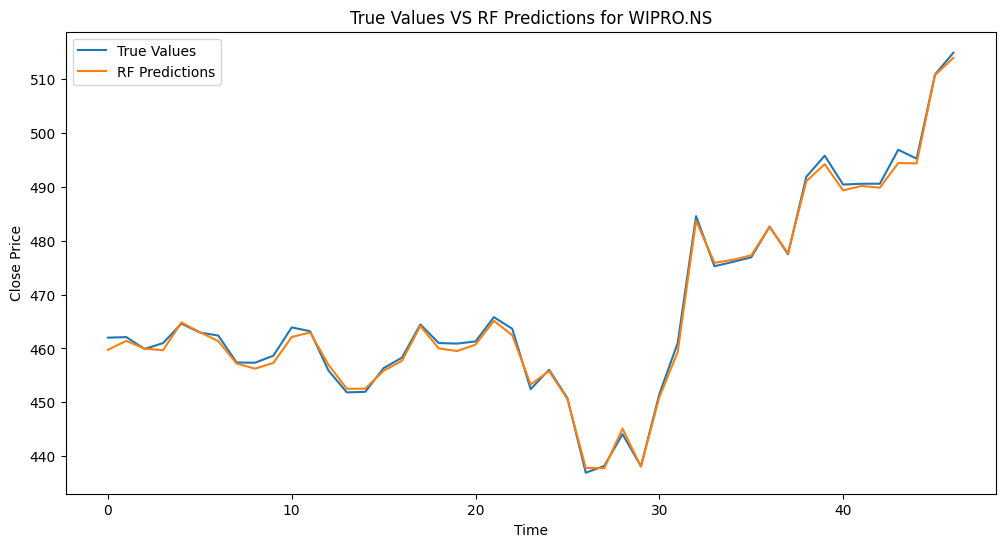

In [45]:
# creating list to store result for each company

rf_stock_results = []


# creating RF model for each company

for ticker in stock_data['ticker'].unique():
  rf_data = stock_data[stock_data['ticker'] == ticker]


  # preparing features and labels for dataset

  rf_features = rf_data[['close', '7-day SMA', '30-day SMA', '12-day EMA',
                         '26-day EMA', 'RSI', 'lag_1', 'lag_2', 'lag_5',
                         'lag_10']]
  rf_labels = rf_data['close']


  # normalise features

  rf_scaler = MinMaxScaler()
  rf_features_scaled = rf_scaler.fit_transform(rf_features)


  # splitting the dataset into train and test in ratio of 80:20

  rf_split_index = int(len(rf_features_scaled) * 0.8)
  X_train, X_test = rf_features_scaled[:rf_split_index], rf_features_scaled[rf_split_index:]
  y_train, y_test = rf_labels[:rf_split_index], rf_labels[rf_split_index:]


  # train RF model
  rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
  rf_model.fit(X_train, y_train)


  # prediction from RF model
  rf_predictions = rf_model.predict(X_test)


  # evaluation of Performance Metrics

  rf_mse = mean_squared_error(y_test, rf_predictions)
  rf_rmse = np.sqrt(rf_mse)
  rf_mae = mean_absolute_error(y_test, rf_predictions)


  # store Performance Metrics for each stock
  rf_stock_results.append({
      'Ticker': ticker,
      'MSE': rf_mse,
      'RMSE': rf_rmse,
      'MAE': rf_mae
  })


  # plot True VS Predicted Price
  plt.figure(figsize=(12, 6))
  plt.plot(y_test.values, label='True Values')
  plt.plot(rf_predictions, label='RF Predictions')
  plt.title(f'True Values VS RF Predictions for {ticker}')
  plt.xlabel('Time')
  plt.ylabel('Close Price')
  plt.legend()
  plt.show()

In [46]:
# converting plot results into DataFrame

stock_results_df = pd.DataFrame(rf_stock_results)
print(stock_results_df)


# calculate Average of all stocks

rf_numeric_columns = stock_results_df.select_dtypes(include=np.number).columns
rf_average_metrics = stock_results_df[rf_numeric_columns].mean()


# print Average
print("RF Average Across All Stocks: ")
print(rf_average_metrics)

           Ticker            MSE        RMSE         MAE
0   ASIANPAINT.NS     277.367491   16.654354    7.831063
1   BAJFINANCE.NS     127.463269   11.289963    8.169728
2     DIVISLAB.NS  120838.528892  347.618367  252.597176
3      HCLTECH.NS    1646.594162   40.578247   30.743851
4     HDFCBANK.NS       6.041806    2.458009    1.745211
5   HINDUNILVR.NS     381.711140   19.537429   13.401751
6    ICICIBANK.NS    1573.286401   39.664674   27.863956
7         INFY.NS       2.148250    1.465691    1.046233
8    KOTAKBANK.NS    1571.975749   39.648149   22.196063
9           LT.NS     241.446542   15.538550    6.797647
10         M&M.NS  297386.528016  545.331576  453.397434
11      MARUTI.NS   12307.421190  110.938817   86.282712
12   NESTLEIND.NS      13.748101    3.707843    2.151786
13    RELIANCE.NS     576.794449   24.016545   10.289688
14     SBILIFE.NS       3.889091    1.972078    1.283047
15         TCS.NS      56.863586    7.540795    5.395975
16       TECHM.NS     132.52741